In [9]:
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import seaborn as sns

import itertools
import ast
import glob
import re
import os
import networkx as nx
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans, AffinityPropagation

import d2v_similarity_compare
# import nlp #check this
%matplotlib inline

pathout = 'sims_summary/resorted2/'

In [66]:
xlabels_txt =['Atm. Sciences', 'Atm. & Space Electricity', 'Biogeosciences', 'Cryosphere', 'Earth & Planetary\nSurface Processes',
 'Earth & Space\nScience Informatics','Education & HR', 'Geodesy', 'Geomagnetism &\nPaleomagnetism', 'Global Envi. Change', 'Hydrology',
 'Mineral & Rock Physics', 'Natural Hazards', 'Near Surface Geophys', 'Nonlinear Geophysics', 'Ocean Sciences',
 'Paleoceanography &\nPaleoclimatology', 'Planetary Sciences', 'Public Affairs', 'SPA-Aeronomy', 'SPA-Magnetospheric Phys',
 'SPA-Solar & Helio. Phys', 'Seismology', "Study of Earth's\nDeep Interior", 'Tectonophysics', 'Union', 'Volcanology, Geochem,\nPetrology']


# 0 Premise
Every year, tens of thousands of earth scientists descend upon San Francisco (recent exceptions being New Orleans and Washington D.C., during construction on the Moscone Center in DTSF) to hear about and present on some 26k abstracts.

In August, scientists from all over the world submit abstracts to the American Geophysical Union for review. During the submission process, they select a session, which in turn belongs to a section, and include abstract text, abstract title, author list, and keywords. By early October the submissions have been evaluated, and the Fall Meeting program is published.

At some point between October and the flight to San Francisco in December, each scientist will spend some time (and it ranges from a some to very little) trying to figure out what science they want to take in during their trip.  Given there are 26k abstracts, most scientists will puruse the titles and author lists--in a few cases skimming actual abstract text--of abstracts in the same section that their abstract is in, or perhaps their section and a few others that are intuitively related.  Not a chance anyone is going to consider all 26k.   


#### AGU at a glance
To help give a sense of the size and structure of AGU Fall Meeting 2018, see the below visualization.  Each node is a section and below each section label is a count of the abstracts presented in that section. 

(From a code perspective, this is out of order because it is based on data I acquired via scraping described below, but I believe it is important context.)

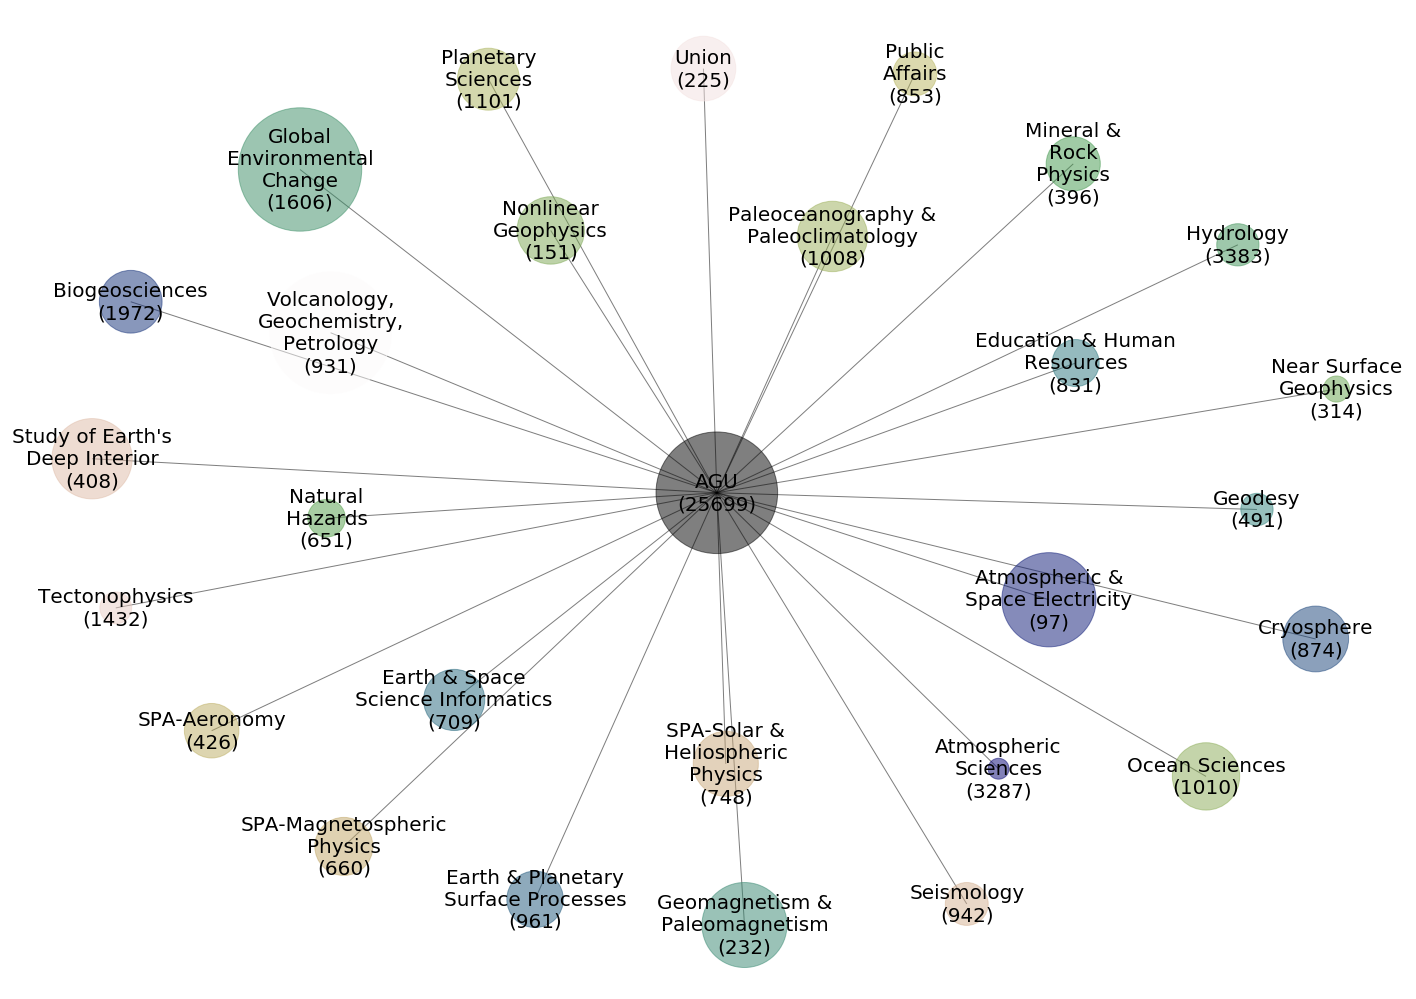

In [14]:
df_agu = pd.read_csv('agu_df.csv')
size = [len(df_agu)] + [len(grp[1]) for grp in df_agu.groupby('section')]
labels_txt =['AGU', 'Atmospheric\nSciences','Atmospheric &\nSpace Electricity','Biogeosciences', 'Cryosphere','Earth & Planetary\nSurface Processes','Earth & Space\nScience Informatics','Education & Human\nResources','Geodesy','Geomagnetism &\nPaleomagnetism','Global\nEnvironmental\nChange','Hydrology','Mineral &\nRock\nPhysics','Natural\nHazards','Near Surface\nGeophysics','Nonlinear\nGeophysics','Ocean Sciences','Paleoceanography &\nPaleoclimatology','Planetary\nSciences','Public\nAffairs','SPA-Aeronomy','SPA-Magnetospheric\nPhysics','SPA-Solar &\nHeliospheric\nPhysics','Seismology', "Study of Earth's\nDeep Interior",'Tectonophysics', 'Union','Volcanology,\nGeochemistry,\nPetrology']
labels_txt = [labels_txt[ind]+'\n('+str(size_ct)+')' for ind, size_ct in enumerate(size)]

fig, (ax) = plt.subplots(1, 1, figsize = (25, 18))
plt.box(False)
G = nx.star_graph(len(labels_txt)-1)
pos = nx.spring_layout(G)
colors = range(len(labels_txt)+5)

mapping = {ik: label for ik, label in enumerate(labels_txt)}

labels_d = {node: mapping[idx] for idx, node in enumerate(G.nodes())}
size2 = [size_ct*4.5 for size_ind, size_ct in enumerate(size) if size_ind>0]

nx.draw_networkx_nodes(G, pos, node_color=colors[:len(labels_txt)], cmap=plt.cm.gist_earth, node_size=size2, ax = ax, alpha = .5)
nx.draw_networkx_edges(G, pos, edge_color='k' , ax=ax, alpha = .5)
nx.draw_networkx_labels(G, pos, labels_d, font_size=20, ax=ax, weight = 'bold')
print(' ')
# plt.savefig('agu_network_overview.png', bbox_inches = 'tight', edgecolor = 'w')


# 1 Getting data  
Scraped AGU Fall Meeting 2018 catolog using scrapy and selenium. 

I broke most of the web scraping into sections to make the workflow both more fault resistant and so that I could run the pieces in parallel. Critical to getting this to work is having a version of the Chromdriver that is compatible with the local version of chrome. 

1. scraped urls for sections: `python3 agu_cat_urls_spider.py` 
2. fed section urls to a spider to get session urls: `echo 0 2 4 6 8 10 12 14 | xargs -n 1 -P 4 python agu_session_urls_spider.py`
3. fed session urls to a spider to get abstract urls: `echo 0 2 4 6 8 10 12 14 | xargs -n 1 -P 4 python agu_abstract_urls_spider.py`
4. fed abstract urls to a spider to get abstract content: `echo 0 2 4 6 8 10 12 14 | xargs -n 1 -P 4 python agu_abstract_html_spider.py`



# 2 Prepping Data

## 2.1 Cleaning data

In [ ]:
json_files =  glob.glob('agu_abstract_text_html_*.json')

dfs = []
for json_file in json_files:
    dfs.append(pd.read_json(json_file))
    
df = pd.concat(dfs)

df.columns = ['authors', 'identifier', 'index_terms', 'meeting', 'section', 'session',
        'abstract_text', 'title', 'url']


In [ ]:
def clean_html(html, ik):
    try:
        html = html[0].split('\n<p>References:')[0]
        html = html.replace('<h2>', '').replace('</h2>', '')
        html = html.replace('<div>', '').replace('</div>', '')
        html = html.replace('<em>', '').replace('</em>', '')
        html = re.sub("(\<sup>).*?(</sup>)", "\g<1>\g<2>", html)
        html = re.sub('<svg.*?</svg>','',html, flags=re.DOTALL)
        html = re.sub('<a.*?</a>','',html, flags=re.DOTALL)
        html = html.replace('<sub>', '').replace('</sub>', '')
        html = html.replace('</p>', '').replace('<p>', '').replace('</p', '')
        html = html.replace('\n', '')
        html = html.replace('<br>', '')
    except:
        print(ik)
        html = np.nan
    return html

In [ ]:
df['abstract_text2'] = [clean_html(text, ik) for ik, text in enumerate(df.abstract_text)]
os.system('afplay /System/Library/Sounds/Sosumi.aiff')


In [ ]:
df['title2'] = [clean_html(text, ik) for ik, text in enumerate(df.title)]
os.system('afplay /System/Library/Sounds/Sosumi.aiff')


## 2.2 Prep Strings

In [ ]:
# Clean text: remove punctuation, stop words, numbers, and lemmatize remaining tokens
def clean_text(text, **kwargs):
    
    # Filter out punctuation and stop words.
    if ('no_stop_words' in kwargs) and (kwargs['no_stop_words'] == True):
        allwords = [str(token.lemma_).translate(str.maketrans('', '', string.punctuation)).lower()
                for token in text
                if not token.is_punct
                  and not token.is_stop
                  and not str(token).isnumeric()]
    else:
    
        allwords = [str(token.lemma_).translate(str.maketrans('', '', string.punctuation)).lower()
                for token in text
                if not token.is_punct
                  and not str(token).isnumeric()]
    
    return ' '.join(allwords)

In [ ]:
df['cleaned_text'] = [clean_text(nlp(text), no_stop_words = True) for text in df.abstract_text2]
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

In [ ]:
df['cleaned_title'] = [clean_text(nlp(text), no_stop_words = True) for text in df.title2]
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

In [ ]:
def make_author_indexterm_strings(term_list):
    labels = []
    for term in term_list:
        term_parts = term[0].split('[')
        labels.append(term_parts[0].rstrip().replace(' ', '').translate(str.maketrans('', '', string.punctuation)).lower())

    return labels


In [ ]:
df['author_strings'] = [make_author_indexterm_strings(authors) for authors in df.authors]
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

In [ ]:
df['index_term_strings'] = [make_author_indexterm_strings(terms) for terms in df.index_terms]
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

## 2.3 Developing Raw Features

In [ ]:
# title features are composed of cleaned title text and corresponding author strings
df['title_features'] = [ df.iloc[ik]['cleaned_title']+' '+' '.join(df.iloc[ik]['author_strings']) for ik in range(len(df))]

# abstract features are composed of title features and corresponding cleaned abstract string
df['abstract_features'] = [ df.iloc[ik]['title_features']+' '+df.iloc[ik]['cleaned_text'] for ik in range(len(df))]

In [ ]:
df =df.set_index('identifier')
df.isnull().sum(axis = 0)
df = df.dropna()
df.to_csv('agu_df.csv')

# 3 Training Doc2Vec models 

## 3.1 Constructing Doc2Vec parameter combinations 

Used itertools to generate parameter combinations to search model space for each of abstract and title feature sets as csv.

Same code was used to generate a second set of combinations with parameters that appeared to improve scores most. 

In [ ]:
import itertools
import pandas as pd
param_lst = []

min_alpha_range = [.0002]#list(np.arange(.0001,.0004,.0002))
alpha_range = [.02]#list(np.arange(.01,.04,.01))
min_count_range = [16]#list(range(8,20,4))
vector_size_range = [11, 14]
negative_range = list(range(1,2))
window_range = [10,12,14,18]
dm_range = [1]

for ik, tple in enumerate(itertools.product(min_alpha_range, alpha_range, min_count_range, vector_size_range, negative_range, window_range,dm_range)):
    params = {}
    for im, key in enumerate(['min_alpha', 'alpha', 'min_count', 'vector_size', 'negative', 'window', 'dm']):
        params[key] = tple[im]
    param_lst.append(params)
    
pd.DataFrame(param_lst).to_csv('d2v_param_sets2.csv')

## 3.2 Training Doc2Vec models

I spun up AWS EC2 instances to train doc2vec models: `python3 run_d2v_model_train.py` which calls `d2v_model_train.py`

Initially I trained 24 models corresponding ot 24 different parameterizations for doc2vec for each of `abstract_features` and `title_features`.  After initial analysis, I trained 8 more parameterizations.

# 4 Doc2Vec Similarity 

## 4.1 Calculating closest 4 sections

A significant component of this study was to understand whether scientists really could capture the most relevant work to theirs by attending talks only in their section, and if, failing that, looking at their section and a few "nearby" sections would cover their area of interest.  

Initially, I developed a method for describing four nearby sections for each section based on the doc2vec description of each abstract.  Subsequently I investigated a second method using keywords assigned by authors to their abstracts upon submission. 

### 4.1.1 Based on Feature Content

I ran `python3 run_find_4closest_sections_to_section.py`, which in turn calls `find_4closest_sections_to_section.py` on an EC2 instance.  Since the "closest four" is based on the doc2vec features, each model parameterization-feature type has its own list. 

The idea behind the method for finding the sections closest to seed section is to collect the top 50 most similar abstracts to each abstract in the seed section, group those by their sections, average of those scores and record the top four as the "closest" sections.

### 4.1.2 Based on Abstract Keywords

As a follow up approach, I constructed a model invariant set of closest four sections based on the keyword assigned to abstracts by authors.  The below code calculates the percent different the key terms associated with one section are from another.  Four lowest scoring sections become the closest four by keyword.

In [ ]:
sec_grps = df_agu.groupby('section')
for grp in sec_grps:
    # creates a dictionary of all key term associated with a given section
    for ik in range(len(grp[1])):
        d_sections[grp[0]] +=ast.literal_eval(grp[1].iloc[ik]['index_term_strings'])
        

sec1 = []
sec2 = []
scores = []
for section1 in set(df_agu['section']):
    print(section1)
    for section2 in set(df_agu['section']):
        if section1 != section2:
            # calculate the difference between the set of key words of one section an another section
            set1 = set(d_sections[section1])-set(d_sections[section2])
            # record the percent different the different set is relative to the total length of the set
            scores.append(len(list(set1))/len(set(d_sections[section1])))
            sec1.append(section1)
            sec2.append(section2)
            
closest4_df = pd.DataFrame({'sec1':sec1, 'sec2':sec2, 'scores':scores})

closest4_df.sort_values(['sec1', 'scores','sec2' ], ascending = True )

closest4_d = {}
sec_grps = closest4_df.groupby('sec1')
for grp in sec_grps:
    closest4_d[grp[0]]= grp[1].sort_values(['scores', 'sec2'])['sec2'][:4].values

pd.DataFrame(closest4_d).to_csv('closest_sections_by_keyword.csv')

## 4.2 Calculating Doc2Vec Similarity

Deployed to Amazon Web Services in 4 EC2 instances. 

For each `Doc2Vec` model:  
- `run_dv2sims_to_sim_exp.py` runs `d2v_sims_regrouper.py` in 1000 abstract batches
- `d2v_sims_regrouper.py` 
    - calculates similarity between each abstract and all other abstracts for title features 
    - calculates similarity between each abstract and all other abstracts for abstract features 
    - calculated average similarity for each abstract between that abstract and the 60 most similary abstracts in:
        - its section
        - its section + four closest sections
        - all sections


In [ ]:
import pandas as pd
import numpy as np
import csv, itertools, ast, sys, gzip, time, subprocess
from scipy import stats


def main():

    def get_scores_inds(row, n_abstracts, df, sections):
        scores = []
        inds = []
        ik = 0

        if len(sections)>0:
            while len(scores)<n_abstracts and ik < len(row):
                if df.iloc[int(row[ik][0])]['section'] in sections:
                    scores.append(row[ik][1])
                    inds.append(row[ik][0])
                ik +=1
        else:
            while len(scores)<n_abstracts and ik < len(row):
                scores.append(row[ik][1])
                inds.append(row[ik][0])
                ik +=1

        return [scores, inds]

    def get_scores_a_of_b(sim_scores_a, sim_inds_a, sim_inds_b):
        lst = [sim_scores_a[int(sim_inds_a.index(str(sim_inds_b[ip])))] for ip in range(len(sim_inds_b))]
        return lst

    save_file = 'sims_summary/sims_'+sys.argv[1]+'/sims_summary_five_sections+_params_'+sys.argv[1]+'_'+sys.argv[2]+'.csv'
    cmd = 'aws s3 ls '+'s3://agu-thinkful-capstone/'+save_file
    response = subprocess.call(cmd, shell = True)
    if str(response) == str(0):
        print('already calculated')	
        
    else:
        csv.field_size_limit(100000000)
        t1 = time.time()
        df = pd.read_csv('agu_df.csv', engine='python')
        df_closest_sections_tf = pd.read_csv('closest_sections/closest_sections_title_features_params_'+str(sys.argv[1])+'.csv', encoding='utf8', engine='python')
        df_closest_sections_af = pd.read_csv('closest_sections/closest_sections_abstract_features_params_'+str(sys.argv[1])+'.csv', encoding='utf8', engine='python')
        df_closest_sections_kw = pd.read_csv('closest_sections_by_keyword.csv', encoding='utf8', engine='python')

        d = {feature : {'n':[], 'ttest_p':[], 'mean':[], 'std':[]} for feature in ['title_features', 'abstract_features', 'abstracts_of_titles', 'titles_of_abstracts']}
        all_sections = dict(d)
        single_section = dict(d)
        five_sections = dict(d)
        five_sections_kw = dict(d)

        print('check point', file=sys.stderr)

        n_abstracts = 60

        with open('sims_title_features/sims_'+str(sys.argv[1])+'/d2v_title_features_params_'+str(sys.argv[1])+'_'+str(sys.argv[2])+'.csv') as f1, open('sims_abstract_features/sims_'+str(sys.argv[1])+'/d2v_abstract_features_params_'+str(sys.argv[1])+'_'+str(sys.argv[2])+'.csv') as f2:
            csv_titles  = csv.reader(f1)
            csv_abstracts  = csv.reader(f2)
            next(csv_titles, None)
            next(csv_abstracts, None)
            print('loaded csvs', file=sys.stderr)

            for title_row_tmp,abstract_row_tmp in zip(csv_titles, csv_abstracts):
                title_row = ast.literal_eval(title_row_tmp[2])
                abstract_row = ast.literal_eval(abstract_row_tmp[2])

                title_inds = [pair[0] for pair in title_row]
                title_scores = [pair[1] for pair in title_row]

                abstract_inds = [pair[0] for pair in abstract_row]
                abstract_scores = [pair[1] for pair in abstract_row]

                ik = int(title_row_tmp[1])
                if ik%100 == 0:
                    print(ik, file=sys.stderr)

                experiments = [[all_sections, {'title_features':[], 'abstract_features':[] }, 'all_sections'], 
                        [single_section, {'title_features':[df.iloc[ik]['section']], 'abstract_features':[df.iloc[ik]['section']] }, 'single_section'], 
                        [five_sections, {'title_features': list(df_closest_sections_tf[df.iloc[ik]['section']]) + [df.iloc[ik]['section']], 'abstract_features':list(df_closest_sections_af[df.iloc[ik]['section']]) + [df.iloc[ik]['section']] }, 'five_sections' ],
                        [five_sections_kw, {'title_features': list(df_closest_sections_kw[df.iloc[ik]['section']]) + [df.iloc[ik]['section']], 'abstract_features':list(df_closest_sections_kw[df.iloc[ik]['section']]) + [df.iloc[ik]['section']] }, 'five_sections_kw' ]]

                # section limitations:
                for [exp_d, sections_d, exp_label] in experiments:

                    inds_d = {}
                    score_d = {}

                    for [feature, row] in [['title_features', title_row], ['abstract_features', abstract_row]]:
                        [scores, inds] = get_scores_inds(row, n_abstracts, df, sections_d[feature])
                        score_d[feature] = scores
                        exp_d[feature]['mean'].append(np.mean(scores))
                        exp_d[feature]['std'].append(np.std(scores))
                        inds_d[feature] = inds

                    # abstracts of titles, then titles of abstracts
                    for [feature, compound_feature] in [['title_features', 'abstracts_of_titles'], ['abstract_features', 'titles_of_abstracts']]:
                        scores = get_scores_a_of_b(abstract_scores, abstract_inds, inds_d[feature])
                        exp_d[compound_feature]['mean'].append(np.mean(scores))
                        exp_d[compound_feature]['std'].append(np.std(scores))
                        exp_d[compound_feature]['ttest_p'].append(stats.ttest_rel(scores, score_d[feature])[1])
                    
                    pd.DataFrame(exp_d).to_csv('sims_summary/sims_'+sys.argv[1]+'/sims_summary_'+exp_label+'_params_'+sys.argv[1]+'_'+sys.argv[2]+'.csv')
                    cmd = ' '.join(['aws s3 cp sims_summary/sims_'+sys.argv[1]+'/sims_summary_'+exp_label+'_params_'+sys.argv[1]+'_'+sys.argv[2]+'.csv', 's3://agu-thinkful-capstone/sims_summary/sims_'+sys.argv[1]+'/sims_summary_'+exp_label+'_params_'+sys.argv[1]+'_'+sys.argv[2]+'.csv'])
                    subprocess.call(cmd, shell = True)

        print(sys.argv[1], sys.argv[2], 'sims are done', time.time()-t1, file=sys.stderr)


        for feature in ['title_features', 'abstract_features']:
            cmd = 'rm sims_'+feature+'/sims_'+str(sys.argv[1])+'/d2v_'+feature+'_params_'+str(sys.argv[1])+'_'+str(sys.argv[2])+'.csv'
            print(cmd, file= sys.stderr)
            subprocess.call(cmd, shell = True)
        print('deleted ec2 similarity data')

if __name__ == '__main__':
    main()




## 4.3 Analyzing Doc2Vec Similarity

### 4.3.1 Processing of EC2 Doc2Vec Similarity Calculaions

In [ ]:
# One time write: 
# build csv files into section-feature-param files where there is one row per abstract and 
# each row contains the mean and standard deviation of the similarity score between that abstract
# and the 60 most similar abstracts that satisfy the sections constraint

sections_d = {'single_sections':'S1', 'five_sections':'S5', 'all_sections':'SA'}

for ik in range(30, 38):
    pathin = 'sims_summary/sims_'+str(ik)+'/'
    pathout = 'sims_summary/resorted2/'
    for key in sections_d.keys():
        feature_sets = {'title_features':[], 'abstract_features':[], 'abstracts_of_titles':[], 
                            'titles_of_abstracts':[]}
        for ip in range(0,25500, 1000):
            df = pd.read_csv(pathin+'sims_summary_'+key+'_params_'+str(ik)+'_'+str(ip)+'.csv')
            for feature in feature_sets.keys():
                d = {}
                for im, label in enumerate(df['Unnamed: 0']): 
                    if (label != 'n'):
                        d[label]= ast.literal_eval(df[feature][im])
                if feature in ['abstract_features', 'title_features']:
                    d.pop('ttest_p')
                feature_sets[feature].append(pd.DataFrame(d))
        for feature_key in feature_sets.keys():
            write_path = pathout+'sim_summary_'+str(ik)+'_'+feature_key+'_'+sections_d[key]+'.csv'
            pd.concat(feature_sets[feature_key]).to_csv(write_path)
        
        

In [ ]:
# one time write: 
# build file reference list of all runs (with or without mean and std info)
d = {'params':[], 'S':[], 'AT':[], 'filename':[], 'mean':[], 'std':[]}
feature_sets = ['title_features','abstract_features', 'abstracts_of_titles', 'titles_of_abstracts']


for S in ['S1', 'S5', 'SA']:
    for AT in feature_sets:
        d['params']+= [str(ik) for ik in range(30, 38)]
        d['AT']+= [AT for ik in range(30, 38)]
        d['S'] += [S for ik in range(30, 38)]
        d['filename'] += ['sim_summary_'+str(ik)+'_'+AT+'_'+S+'.csv' for ik in range(30, 38)]
        
        # one version includs the mean and std, one just file info
        means = []
        stds = []
        for ik in range(30, 38):
            df = pd.read_csv(pathout+'sim_summary_'+str(ik)+'_'+AT+'_'+S+'.csv')
            means.append(df['mean'].mean())
            stds.append(df['mean'].std())
        d['mean'] += means
        d['std'] += stds

# file info into a csv
pd.DataFrame(d).to_csv('file_names_df2_2.csv')

### 4.3.2 Analyze Doc2Vec Similarity Calculations  

With all the base calculations done, it's time to explore. We have three different "axes" to explore.  Are abstracts more similar to each other when characterized by title text or abstract text?  Is model parameterization 5 more effective than 6?  Are the abstracts most similar to a given abstract all within the same section, or is the average similarity higher when abstracts from additional sections are included?

I structured these questions in the form of a grid. Each column represents one aspect, each row another. In each cell I take all runs that satisfy two constraints, for example, model parameterization 5, title features and compare them with paired ttest(s).  If sets are statistically different, the one with the higher average score is recorded as the "winner" of that cell.  If there are multiple that are not statistically different and (if applicable) have higher average scores than a third, multiple combinations are recorded as "winners".

Row-wise, and column-wise, and table wise winners are calcalated in the same way.

Functions: 
- `find_best`(sets): Goes through a set (size>2) and identifies the best performing model-feature-section comb (or set of combs); takes model-feature-section combination that is untested, and tests it against the prior winners returns one winner if there is a statistically significant one, or set of winners if there are more than one that are not statistically different and score best
- `get_cell_best`(crit1, crit2, d_cell_best, df_1): pull sets for a particular cell, calculate winner(s) of cell
- `get_each_row_col_best`(crit1, crit2, d_cell_best): pull winners from cells in standard table in either a row or column, calculate row or column winnner(s)
- `get_rows_cols_best`(crit1, crit2, d_each_row_each_col_best): pull winners from summary col or row to calculate total row-wise or col-wise winner
- `get_all_best`(crit1, crit2, d_rows_cols_best): pull winners of summary row or col and record best
- `make_file_df`(crit1, crit2, file_df): makes a dataframe for visualizing summary information
- `make_df_summary`(crit1, crit2, d_cell_best, file_df): Runs all helper functions to calculate summary table

In [2]:
# load csv with information about all files; file_names_df_2.csv- refined runs, file_names_df.csv- rough runs
file_df = pd.read_csv('file_names_df_2.csv')

In [3]:
crit1 = 'S'
crit2 = 'AT'
d_cell_best = {'AT': {crit_at: {s:[] for s in ['S1', 'S5', 'SA']} for crit_at in ['abstract_features', 'title_features']}, 'S': {s:{crit: [] for crit in ['abstract_features', 'title_features']} for s in ['S1', 'S5', 'SA']}}

summary_df, best = d2v_similarity_compare.make_df_summary(crit1, crit2, d_cell_best, file_df)
summary_df

Best: ['sim_summary_33_abstract_features_SA.csv']


labels        S1        S5        SA           row summary
0  abstract_features  [33, 32]  [30, 33]      [33]            [33_AF_SA]
0     title_features      [35]      [35]  [33, 31]  [31_TF_SA, 33_TF_SA]
0        col summary   [35_TF]   [35_TF]   [33_AF]            [33_AF_SA]

In [12]:
crit1 = 'params'
crit2 = 'S'
d_cell_best = {'S': {crit_at: {ik:[] for ik in range(30, 38)} for crit_at in ['S1', 'S5', 'SA']}, 'params': {ik:{crit: [] for crit in ['S1', 'S5', 'SA']} for ik in range(30, 38)}}


summary_df, best = d2v_similarity_compare.make_df_summary(crit1, crit2, d_cell_best, file_df)
summary_df

Best: ['sim_summary_33_abstract_features_SA.csv']


labels       30       31       32       33       34       35       36  \
0           S1     [AF]     [TF]     [AF]     [TF]     [AF]     [TF]     [TF]   
0           S5     [AF]     [TF]     [AF]     [AF]     [AF]     [TF]     [AF]   
0           SA     [AF]     [AF]     [AF]     [AF]     [AF]     [TF]     [AF]   
0  col summary  [AF_SA]  [AF_SA]  [AF_SA]  [AF_SA]  [AF_SA]  [TF_SA]  [AF_SA]   

        37 row summary  
0     [AF]  [35_TF_S1]  
0     [AF]  [35_TF_S5]  
0     [AF]  [33_AF_SA]  
0  [AF_SA]  [33_AF_SA]

In [13]:
crit1 = 'params'
crit2 = 'AT'
d_cell_best = {'AT': {crit_at: {ik:[] for ik in range(30, 38)} for crit_at in ['abstract_features', 'title_features']}, 'params': {ik:{crit: [] for crit in ['abstract_features', 'title_features']} for ik in range(30, 38)}}

summary_df, best = d2v_similarity_compare.make_df_summary(crit1, crit2, d_cell_best, file_df)
summary_df

Best: ['sim_summary_33_abstract_features_SA.csv']


labels       30       31       32       33       34       35  \
0  abstract_features     [SA]     [SA]     [SA]     [SA]     [SA]     [SA]   
0     title_features     [SA]     [SA]     [SA]     [SA]     [SA]     [SA]   
0        col summary  [AF_SA]  [AF_SA]  [AF_SA]  [AF_SA]  [AF_SA]  [TF_SA]   

        36       37           row summary  
0     [SA]     [SA]            [33_AF_SA]  
0     [SA]     [SA]  [31_TF_SA, 33_TF_SA]  
0  [AF_SA]  [AF_SA]            [33_AF_SA]

Having looked at the statistical comparison, now let's visualize the data a bet and see how it lays out.

In [5]:
model_compare_df = pd.read_csv('file_names_df2_2.csv')

In [17]:
model_compare_df.sort_values(by = 'mean', ascending = False)

Unnamed: 0  params   S                   AT  \
75          75      33  SA    abstract_features   
74          74      32  SA    abstract_features   
72          72      30  SA    abstract_features   
73          73      31  SA    abstract_features   
65          65      31  SA       title_features   
67          67      33  SA       title_features   
69          69      35  SA       title_features   
64          64      30  SA       title_features   
66          66      32  SA       title_features   
77          77      35  SA    abstract_features   
78          78      36  SA    abstract_features   
76          76      34  SA    abstract_features   
79          79      37  SA    abstract_features   
70          70      36  SA       title_features   
71          71      37  SA       title_features   
68          68      34  SA       title_features   
37          37      35  S5       title_features   
40          40      30  S5    abstract_features   
43          43      33  S5    abstract_features   
33          33      31  S5       title_features   
35          35      33  S5       title_features   
42          42      32  S5    abstract_features   
41          41      31  S5    abstract_features   
32          32      30  S5       title_features   
34          34      32  S5       title_features   
44          44      34  S5    abstract_features   
46          46      36  S5    abstract_features   
38          38      36  S5       title_features   
47          47      37  S5    abstract_features   
45          45      35  S5    abstract_features   
..         ...     ...  ..                  ...   
80          80      30  SA  abstracts_of_titles   
22          22      36  S1  abstracts_of_titles   
81          81      31  SA  abstracts_of_titles   
54          54      36  S5  abstracts_of_titles   
17          17      31  S1  abstracts_of_titles   
21          21      35  S1  abstracts_of_titles   
62          62      36  S5  titles_of_abstracts   
59          59      33  S5  titles_of_abstracts   
57          57      31  S5  titles_of_abstracts   
18          18      32  S1  abstracts_of_titles   
89          89      31  SA  titles_of_abstracts   
86          86      36  SA  abstracts_of_titles   
87          87      37  SA  abstracts_of_titles   
84          84      34  SA  abstracts_of_titles   
82          82      32  SA  abstracts_of_titles   
23          23      37  S1  abstracts_of_titles   
50          50      32  S5  abstracts_of_titles   
51          51      33  S5  abstracts_of_titles   
94          94      36  SA  titles_of_abstracts   
55          55      37  S5  abstracts_of_titles   
91          91      33  SA  titles_of_abstracts   
83          83      33  SA  abstracts_of_titles   
49          49      31  S5  abstracts_of_titles   
52          52      34  S5  abstracts_of_titles   
19          19      33  S1  abstracts_of_titles   
20          20      34  S1  abstracts_of_titles   
85          85      35  SA  abstracts_of_titles   
53          53      35  S5  abstracts_of_titles   
61          61      35  S5  titles_of_abstracts   
93          93      35  SA  titles_of_abstracts   

                                     filename      mean       std  
75    sim_summary_33_abstract_features_SA.csv  0.793472  0.021984  
74    sim_summary_32_abstract_features_SA.csv  0.793064  0.024072  
72    sim_summary_30_abstract_features_SA.csv  0.792713  0.024836  
73    sim_summary_31_abstract_features_SA.csv  0.792578  0.026121  
65       sim_summary_31_title_features_SA.csv  0.790847  0.026873  
67       sim_summary_33_title_features_SA.csv  0.790470  0.027133  
69       sim_summary_35_title_features_SA.csv  0.787797  0.090845  
64       sim_summary_30_title_features_SA.csv  0.780122  0.038126  
66       sim_summary_32_title_features_SA.csv  0.779702  0.035483  
77    sim_summary_35_abstract_features_SA.csv  0.728590  0.028009  
78    sim_summary_36_abstract_features_SA.csv  0.728454  0.027240  
76    sim_summary_34_abst

In [6]:
param_df = pd.read_csv('d2v_param_sets2.csv')

In [7]:
model_compare_df.columns
d_tmp = {'window':[], 'min_count': [], 'vector_size': []}
for ik in range(len(model_compare_df)):
    for key in ['window', 'vector_size', 'min_count']:
        d_tmp[key].append(param_df[param_df['Unnamed: 0'] == model_compare_df.iloc[ik]['params']][key].values[0])
        
for key in ['window', 'vector_size', 'min_count']:
    model_compare_df[key] = d_tmp[key]

Text(0.5, 0, 'model index (feature_set-param-sections)')

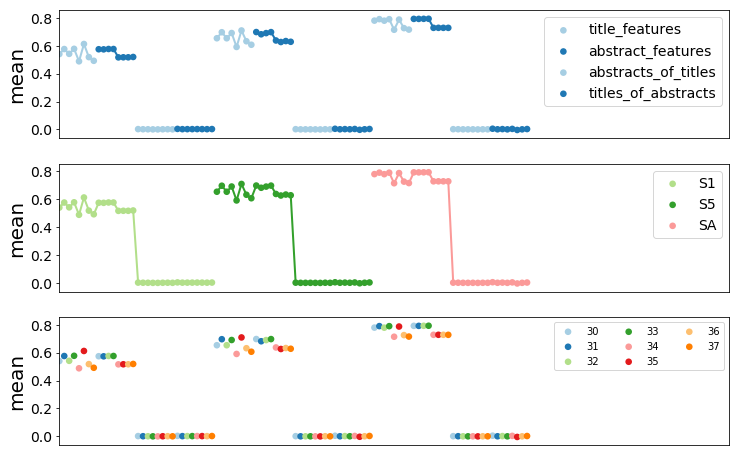

In [11]:
# Create a set of plots with model run on x axis, colored in different ways

filteredbyAT = model_compare_df[(model_compare_df.AT != 'abstracts_of_titles') | (model_compare_df.AT != 'titles_of_abstracts')]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize = (12, 8))
sns.pointplot( x='Unnamed: 0', y="mean", data=filteredbyAT,  ci="std", hue='AT', palette = sns.color_palette("Paired")[0:2], legend=True, ax= ax1, scale = .75)
sns.pointplot( x='Unnamed: 0', y="mean", data=filteredbyAT, ci="std", hue='S', palette = sns.color_palette("Paired")[2:5], legend=True, ax= ax2,  scale = .75)
sns.pointplot( x='Unnamed: 0', y="mean", data=filteredbyAT,  ci="std", hue='params', palette = sns.color_palette("Paired"), legend=False, ax= ax3,  scale = .75)


for ax in [ax1, ax2, ax3]:
    ax.yaxis.label.set_size(20)
    ax.xaxis.set_visible(False)
#     ax.set_xticklabels([])
    ax.legend(prop=dict(size=14))
    ax.set_xlim([0, len(model_compare_df)+40])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
        
ax3.legend(ncol=3)
ax3.xaxis.set_visible(False)
ax3.set_xlabel('model index (feature_set-param-sections)', fontsize = 20)
# ax3.get_legend().remove()


In [12]:
df_agu = pd.read_csv('agu_df.csv')
df_agu_min = df_agu.iloc[:, ~df_agu.columns.isin(['meeting', 'abstract_text2',
       'title2', 'cleaned_text', 'cleaned_title', 'author_strings',
       'index_term_strings', 'title_features', 'abstract_features'])] 

In [18]:
df_lst = []

for ik in [33]:
    for S in ['S1','S5', 'SA']:
        load_path = pathout+'sim_summary_'+str(ik)+'_abstract_features_'+S+'.csv'
        df_tmp = pd.read_csv(load_path)
        df_agu_min.loc[:,['mean']] = df_tmp['mean']
        df_agu_min.loc[:,['S']] = [S for ip in range(len(df_agu))]
        df_agu_min.loc[:,['param']] = [ik for ip in range(len(df_agu))]
        df_lst.append(df_agu_min.copy())

df_sns_af = pd.concat(df_lst)

In [36]:
# For curiosity, seeing which abstract is most closely related to 60 other abstracts
df_sns_tf.sort_values(by = 'mean', ascending = False)

Unnamed: 0  identifier  \
9857         9857  NS31C-0767   
7763         7763    ED33A-08   
727           727    OS44B-05   
3864         3864  SA31C-3448   
6043         6043   S43D-0641   
8173         8173    ED52A-08   
14683       14683   T23A-0336   
810           810  OS51F-1324   
11728       11728   B41G-2787   
14725       14725   T23C-0378   
7943         7943  ED41D-1216   
12819       12819   T43E-0440   
25140       25142     P51B-06   
17675       17675     A24A-02   
12289       12289   B51L-2118   
10090       10090  OS11F-1462   
19009       19009    PA34A-07   
2129         2129    GC13B-10   
8164         8164  ED51I-0740   
17007       17007   A13K-2600   
1885         1885   G51C-0485   
21478       21480  IN53E-0653   
20988       20989  IN23A-0756   
21203       21205    IN41C-34   
3682         3682  SA11C-2745   
11107       11107     B24A-03   
11101       11101   B23M-2702   
18866       18866    PA31A-08   
14625       14625   T21G-0302   
7665         7665  ED23E-0949   
...           ...         ...   
10413       10413    AE11A-03   
10433       10433  AE11B-2713   
10460       10460    AE21A-02   
10432       10432  AE11B-2712   
10424       10424  AE11B-2704   
10447       10447  AE13B-2719   
10448       10448  AE13B-2720   
10416       10416    AE11A-06   
10469       10469  AE21B-3124   
10444       10444    AE13A-08   
10495       10495    AE31A-01   
10420       10420  AE11B-2700   
10439       10439    AE13A-03   
10496       10496    AE31A-02   
10458       10458  AE13B-2730   
10501       10501    AE31A-07   
10484       10484  AE21B-3139   
10452       10452  AE13B-2724   
10485       10485  AE21B-3140   
10475       10475  AE21B-3130   
10488       10488    AE24A-02   
10412       10412    AE11A-02   
10457       10457  AE13B-2729   
10503       10503  AE33A-3396   
10450       10450  AE13B-2722   
10426       10426  AE11B-2706   
10455       10455  AE13B-2727   
10442       10442    AE13A-06   
10445       10445  AE13B-2717   
10502       10502    AE31A-08   

                                                 authors  \
9857   [['Uhlemann, S*, Lawrence Berkeley National La...   
7763   [['Wilkening, B*, AZ Project WET, University o...   
727    [['Miller, I  M*, WA SeaGrant-Peninsula Cllg, ...   
3864   [['Pan, W*, Institute of Atmospheric Physics, ...   
6043   [['Meng, X*, Southern California Earthquake Ce...   
8173   [['Linder, C*, Woods Hole Oceanographic Instit...   
14683  [['Lai, L  S  H*, Department of Earth Sciences...   
810    [['Santra, M*, Institute for Geophysics, Jacks...   
11728  [['Villa, J  A*, Department of Civil, Environm...   
14725  [['Haproff, P  J*, Earth and Ocean Sciences, U...   
7943   [['Shumway, Z*, Jennings Community Learning Ce...   
12819  [['Cabrera, L*, University of Chile, Santiago,...   
25140  [['Juanola-Parramon, R*, NASA Goddard Space Fl...   
17675  [['Pilewskie, P*, University of Colorado Bould...   
12289  [['Jeong, H*, Korea Institute of Ocean Science...   
10090  [['Brothers, L  L*, USGS Coastal and Marine Sc...   
19009  [['Larsen, K  W*, Mayor, Town of Nederland Col...   
2129   [['Stocker, B  D*, CREAF, Cerdanyola Del Valle...   
8164   [['Gaudet, B  J*, Pennsylvania State Universit...   
17007  [['Moncrieff, M  W*, National Center for Atmos...   
1885   [['Starek, M  J*, School of Engineering and Co...   
21478  [['Lafuente, B*, NASA Ames Research Center, Mo...   
20988  [['Jabot, M*, SUNY at Fredonia, Fredonia, NY, ...   
21203  [['Gallaher, D  W*, National Snow and Ice Data...   
3682   [['Blagoveshchenskaya, N  F*, Arctic and Antar...   
11107  [['Peralta, A  L*, Department of Biology, East...   
11101  [['Gao, L*, Center for Social and Environmenta...   
18866  [['Bradley-Cook, J*, 500 Women Scientists, Was...   
14625  [['Errzuriz-Henao, C*, Universidad Nacional de...   
7665   [['Venzke, E*, Smithsonian Inst-Mineral Scies,...   
...                                                  ...   
10413  [['Hare, B*, University of Gronin

In [22]:
sec_list_labels = ['Near Surface\nGeophysics', 'Nonlinear\nGeophysics', 'SPA-Solar\n& Heliospheric\nPhysics', 
                   'Earth & Space\nScience Informatics', 'Seismology',  'Ocean Sciences', 'Biogeosciences', 
                   'Public Affairs', 'SPA-Aeronomy', 'Geomagnetism\n& Paleomagnetism', 
                   'Atmospheric\n& Space Electricity', 'Tectonophysics', 'Geodesy', 'Cryosphere', 
                   'Global Environmental\nChange', 'Volcanology,\nGeochemistry,\nPetrology', 
                   'Planetary Sciences', 'Union', 'Atmospheric\nSciences', 'Hydrology', 
                   'Paleoceanography\n& Paleoclimatology', "Study of Earth's\nDeep Interior", 
                   'Earth & Planetary\nSurface Processes', 'Natural Hazards', 'Education & Human\nResources', 
                   'Mineral\n& Rock Physics', 'SPA-Magnetospheric\nPhysics']

sec_list = [word.replace('\n', ' ').replace('&', 'and') for word in sec_list_labels]

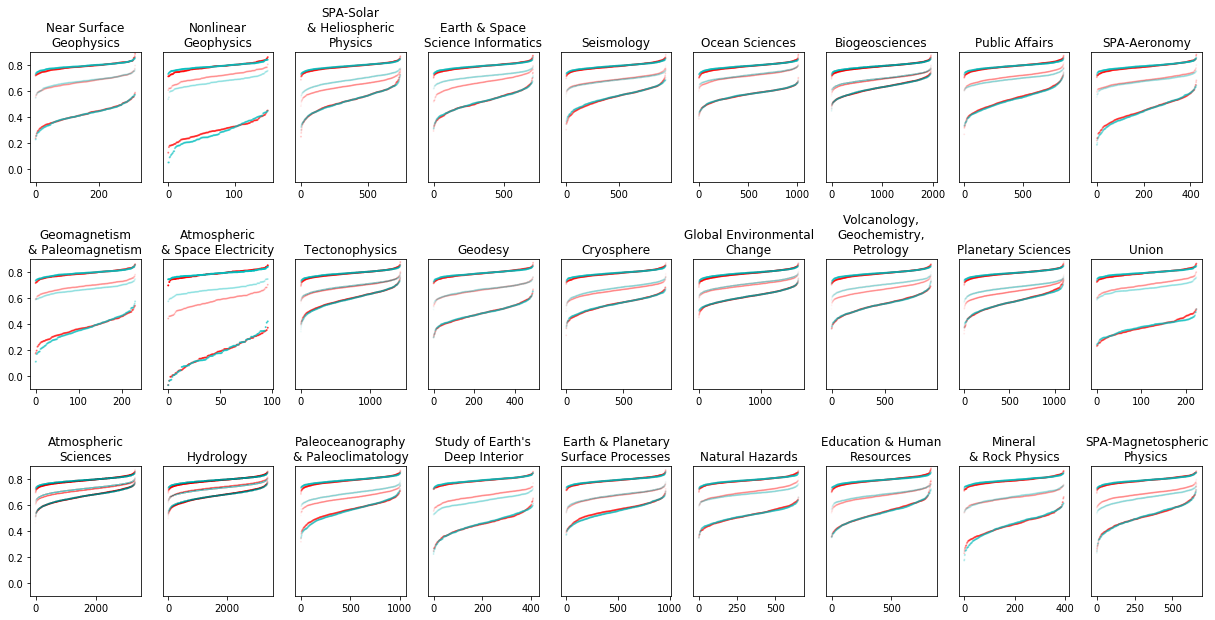

In [40]:
# For one model parameterization, this plot shows average similarity scores for each abstract for each of 
# title and feature runs calcullated with each of the section limitations in ascending order. That's a mouthful,
# but what these plots show is that there isn't a visibly large difference between title and abstract features 
# in most cases, that average similarity calculated without section constraints score better than with five 
# section limitations, which in turn performed better than limiting to one section. 


c_lst = ['r', 'c', 'b']
a_lst = [20, 60, 90]
c_line_lst = ['m', 'b']

S_list = list(set(df_sns_tf['S']))

fig = plt.figure(constrained_layout=False, figsize = (21, 10))
#make outer gridspec
outer = gridspec.GridSpec(3, 1, figure = fig, height_ratios = [1, 1, 1], hspace = .6, wspace=0.1) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec = outer[0], hspace = .05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec = outer[1], hspace = .05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec = outer[2], hspace = .05)

ind2 = 0
for [seclist, gs] in [[sec_list[:9], gs1], [sec_list[9:18], gs2], [sec_list[18:], gs3]]:
    ind = 0
    for sec in seclist:
        ax = plt.subplot(gs[ind])
        for af_tf_ind, df_tmp in enumerate([df_sns_tf, df_sns_af]):
            for S_ind, S in enumerate(S_list):
                df_sec_S_tmp = df_tmp[(df_tmp['section'] ==sec) & (df_tmp['S'] == S)]
                leng = len(df_sec_S_tmp['mean'])
                ax.scatter([ik for ik in range(leng)], np.sort(df_sec_S_tmp['mean']), alpha = a_lst[S_ind]*1/leng, c = c_lst[af_tf_ind], s =[1 for im in range(leng)])
        if ind<9:
            ax.set_title(sec_list_labels[ind2])
        ind2+=1
        ax.set_ylim([-.1,.9])
        
        if ind not in [0, 9, 18]:
            ax.yaxis.set_visible(False)
        ind+=1


In [78]:
df = pd.read_csv('agu_df.csv')

set_len = []
avg_score = []
sec_labels = []

feature = 'title_features'
model = Doc2Vec.load('models/d2v_'+feature+'_params_'+'9'+'.model')

for ik in range(len(df)):
    new_vector = model.infer_vector(df.iloc[ik][feature].split())
    sims = model.docvecs.most_similar([new_vector], topn=60) #N.B. This was very sensitive to class imbalance.  topn = 100 exposed the fact that certain sections just have so many more abstracts
    sim_sec_labels = []
    sim_scores = []
    for pair in sims:
        sim_sec_labels.append(df.iloc[int(pair[0])]['section'])
        sim_scores.append(pair[1])
    set_len.append(len(set(sim_sec_labels)))
    avg_score.append(np.mean(sim_scores))
    sec_labels.append(df.iloc[ik]['section'])
    
df_SA_set_len = pd.DataFrame({'sec_labels': sec_labels, 'avg_score':avg_score, 'set_len':set_len})



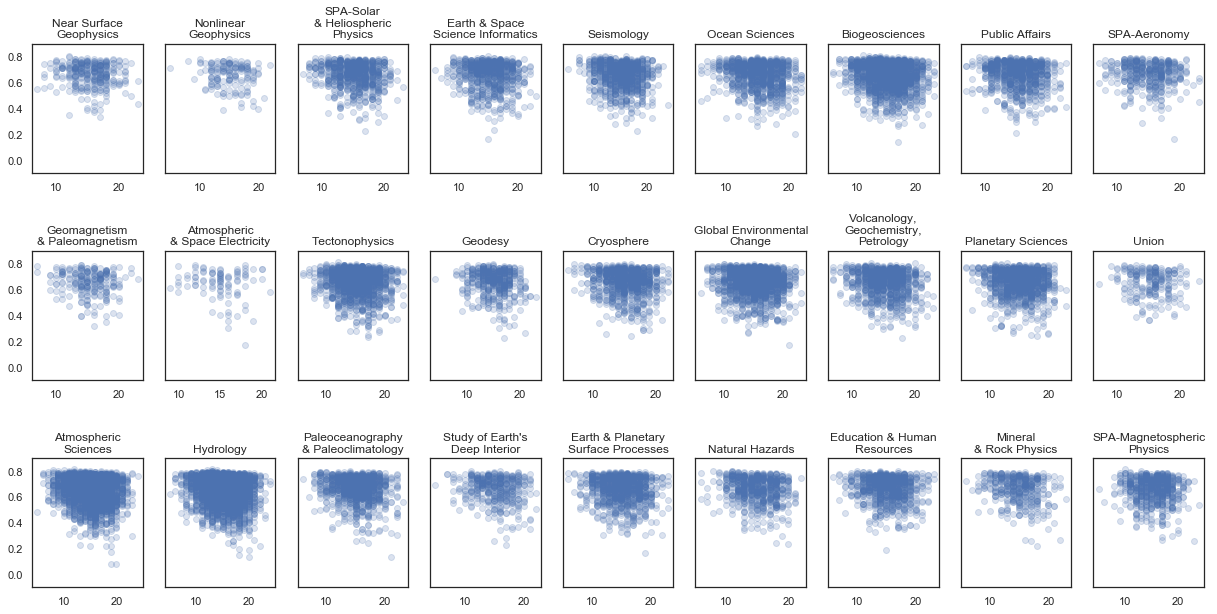

In [99]:
fig = plt.figure(constrained_layout=False, figsize = (21, 10))
#make outer gridspec
outer = gridspec.GridSpec(3, 1, figure = fig, height_ratios = [1, 1, 1], hspace = .6, wspace=0.1) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec = outer[0], hspace = .05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec = outer[1], hspace = .05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec = outer[2], hspace = .05)

ind2 = 0
for [seclist, gs] in [[sec_list[:9], gs1], [sec_list[9:18], gs2], [sec_list[18:], gs3]]:
    ind = 0
    for sec in seclist:
        x = df_SA_set_len[df_SA_set_len['sec_labels'] == sec]['avg_score']
        y = df_SA_set_len[df_SA_set_len['sec_labels'] == sec]['set_len']
        
        ax = plt.subplot(gs[ind])
        ax.scatter(y, x, alpha = .2)
        if ind<9:
            ax.set_title(sec_list_labels[ind2])
        ind2+=1
        ax.set_ylim([-.1,.9])
        
        if ind not in [0, 9, 18]:
            ax.yaxis.set_visible(False)
        ind+=1

Text(0, 0.5, 'Avg. Score')

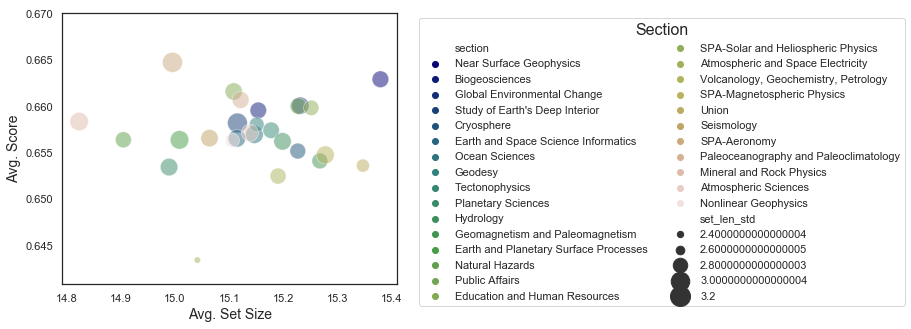

In [131]:
tmp_mean = []
tmp_std = []
tmp_score = []
tmp_secs = list(set(df.section))
for sec in tmp_secs:
    x = df_SA_set_len[df_SA_set_len['sec_labels'] == sec]['avg_score']
    y = df_SA_set_len[df_SA_set_len['sec_labels'] == sec]['set_len']
    tmp_score.append(np.mean(x))
    tmp_mean.append(np.mean(y))
    tmp_std.append(np.std(y))
    
df_SA_set_len_summary = pd.DataFrame({'section': tmp_secs, 'set_len': tmp_mean, 'set_len_std': tmp_std, 'avg_score':tmp_score})

cmap=plt.cm.gist_earth
plt.cm.register_cmap("gist_eath", cmap)
sns.set_palette('gist_eath', n_colors=27)

fig, (ax1) = plt.subplots(1, 1,figsize = (6, 5))
sns.scatterplot(x="set_len", y="avg_score", hue="section", size="set_len_std",
            sizes=(40, 400), alpha=.5,
            data=df_SA_set_len_summary)

ax1.legend(title= 'Section',  title_fontsize = 16,ncol=2, loc = 2, bbox_to_anchor=(1.05, 1))
ax1.set_xlabel('Avg. Set Size', fontsize = 14)
ax1.set_ylabel('Avg. Score', fontsize = 14)


# 5 Clustering Doc2Vec Features

The next part of this study was to cluster the `Doc2vec` vectors by unsupervised clustering algorithms and compare resulting sillohuette coefficients to silohuette coefficients yielded when clusters were assigned by section label.

# 6 Supervised Classification

Finally, I trained gradient boosting classifiers and support vector machine classifiers for each model to predict the clustering labels and the section labels to investigate the internal consistency of the groups.


## 5.1 and 6.1 Clustering and Classifier model runs
For perceived efficiency, these two tasks were executed on for each stage EC2 instances together so as to limit the in/out tasks. For each parameter combination (number of clusters, clustering algorithm, doc2vec parameterization, feature set) clustering was done done and recorded, then class-balanced train and test sets were created and used to train and test both GBC and SVM-C models (for consistency).  

Clustering was limited to KMeans and Agglomerative clustering because of time constraints.

`run_cluster_ml.py` ran `cluster_analysis2.py`

In [ ]:
from gensim.models import Doc2Vec
import sys, os, time, subprocess

from sklearn.cluster import KMeans, AgglomerativeClustering#, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import csv
# model feature clustering_key num_clusters function time

def main():
    def move_file_to_s3(file_path):
        cmd = ' '.join(['aws s3 cp ', file_path, 's3://agu-thinkful-capstone/'+file_path])
        subprocess.call(cmd, shell = True)
        print('copied '+file_path+' to s3', file=sys.stderr)

        cmd = 'rm '+file_path
        print(cmd, file= sys.stderr)
        subprocess.call(cmd, shell = True)
        print('removed '+file_path+' from ec2', file=sys.stderr)

    
    def make_clusters(clustering_key,param_range, doc_vecs_df, meta_data, csv_file_name, **kwargs):
        nclusts = []
        param = []
        sscores = [] 
        avg_obs = []
        obs_std = []
        models = []
        labels = []


        for no in param_range:
            t1 = time.time()
            if clustering_key =='kmeans':
                model = KMeans(n_clusters=no, random_state=43).fit(doc_vecs_df)
            elif clustering_key == 'agglomerative':
                model = AgglomerativeClustering(linkage = 'ward', n_clusters= no).fit(doc_vecs_df)
            fdv_clusters = model.labels_
            nclusts.append(len(list(set(fdv_clusters))))
            param.append(no)
            sscores.append(silhouette_score(doc_vecs_df, fdv_clusters, metric='cosine'))
            avg_obs.append(pd.value_counts(fdv_clusters).mean())
            obs_std.append(pd.value_counts(fdv_clusters).std())
            models.append(model)
            labels.append(fdv_clusters)
            with open(csv_file_name, 'a') as csv_file:
                writer = csv.writer(csv_file, delimiter=',')
                writer.writerow(meta_data+ [no, 'make_clusters', time.time()-t1])
            print(meta_data+[no, 'make_clusters', time.time()-t1], file=sys.stderr)

        return models, pd.DataFrame({'nclusts':nclusts, 'param':param, 'sscores':sscores, 'avg_obs':avg_obs, 'obs_std':obs_std, 'labels':labels})


    def make_sil_plot(df, **kwargs):
        obsstd1 = [ i+j for i,j in zip(df['avg_obs'],df['obs_std'])]
        stdneg = [ i-j for i,j in zip(df['avg_obs'],df['obs_std'])]

        fig, ax = fig, ax = plt.subplots(figsize=(6,4))

        ax2 = ax.twinx()
        ax = sns.scatterplot(x = 'param', y = 'sscores', data = df,hue='nclusts', label='Sil. Score', ax=ax)

        ax2 =sns.lineplot(df['param'], df['avg_obs'],color='purple',label='Avg obs per cluster', linewidth=2)
        sns.lineplot(df['param'],obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
        sns.lineplot(df['param'],stdneg,color='r', linewidth=.6)

        ax.set_ylabel('Sil. Score')
        ax.set_xlabel('Number of Clusters')
        ax.axvline(x=df['param'].iloc[df['sscores'].idxmax()],color='r',linestyle='dotted')

        ax.legend(loc='lower left')
        ax2.legend(loc='upper right')
        plt.ylabel('Average Observation per cluster')
        plt.xlabel('Number of Clusters')
        plt.title('Silhouette Scores by Number of Clusters',fontsize=20)

        if 'save_name' in kwargs:
            plt.savefig(kwargs['save_name'], format='svg', bbox_inches='tight')
    
    def make_train_test_inds(df_for_inds):
        balanced_inds_train = []
        for grp in df_for_inds.groupby('labels'):
            balanced_inds_train += grp[1].sample(frac = .8).index.tolist()

        balanced_inds_test = df_for_inds[~df_for_inds.index.isin(balanced_inds_train)].index.tolist()
        return balanced_inds_train, balanced_inds_test

    def make_d2v_df(model, df):
        return pd.DataFrame([model.docvecs[ik] for ik in range(len(df))])

    params_df = pd.read_csv('feature_modelnum_clustermodel2.csv')
    comb_num = int(sys.argv[1])
    clustering_key = params_df.iloc[comb_num]['clustering_key']
    model_num = str(params_df.iloc[comb_num]['model_num'])
    feature = params_df.iloc[comb_num]['feature']
    csv_file_name = 'clustering/ml_logging_d2v_'+clustering_key+'_'+model_num+ '_'+feature+'.csv'
    cmd = 'touch '+ csv_file_name
    subprocess.call(cmd, shell = True)
    meta_data = [model_num, feature, clustering_key]

    # Returns doc2vec modeled vectors
    df = pd.read_csv('agu_df.csv')
    model = Doc2Vec.load('models/d2v_'+feature+'_params_'+model_num+'.model')
    doc_vecs_df = make_d2v_df(model, df)

    param_d = {'kmeans': list(range(2, 27, 1)), 'agglomerative': list(range(2, 27, 1))}#, 'DBSCAN': np.arange(10, 10.78, .03).tolist(), 'DBSCAN_kd': np.arange(10, 10.78, .03).tolist()}
    filter_cols =  ['labels', 'section', 'session', 'labels_sub', 'identifier']
    
    # Clustering Runs
    kmeans_mdls, df_clusters = make_clusters(clustering_key, param_d[clustering_key], doc_vecs_df.iloc[:, ~doc_vecs_df.columns.isin(filter_cols)],meta_data, csv_file_name)
    clustering_csv_file = 'clustering/clustering_d2v_'+clustering_key+'_'+model_num+ '_'+feature+'.csv'
    df_clusters.to_csv(clustering_csv_file)
    move_file_to_s3(clustering_csv_file)

    t1 = time.time()
    silplot_file_name = 'clustering/silplot_d2v_'+clustering_key+'_'+model_num + '_'+feature+'.svg'
    make_sil_plot(df_clusters, save_name = silplot_file_name)
    move_file_to_s3(silplot_file_name)
    with open(csv_file_name, "a") as csv_file:
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerow(meta_data+ [0, 'make_sil_plot', time.time()-t1])
    

    # Supervised Classifier Runs
    d = {'clust_param':[], 'X_train_inds':[], 'X_test_inds':[], 'y_test_cl':[], 'y_test_sl':[], 
        'svc_y_pred_cl':[], 'svc_test_score_cl': [], 'svc_train_score_cl': [],'gbc_y_pred_cl':[], 'gbc_test_score_cl':[], 'gbc_train_score_cl':[],
        'svc_y_pred_sl':[], 'svc_test_score_sl': [], 'svc_train_score_sl': [],'gbc_y_pred_sl':[], 'gbc_test_score_sl':[], 'gbc_train_score_sl':[] }
    
    doc_vecs_df['section'] = df['section']
    for ik in range(len(df_clusters)):
        doc_vecs_df['labels'] = df_clusters.iloc[ik]['labels']
        X_train_inds, X_test_inds = make_train_test_inds(doc_vecs_df)
        supclass_X_train, supclass_X_test =  doc_vecs_df.iloc[X_train_inds], doc_vecs_df.iloc[X_test_inds]

        supclass_y_train_cl, supclass_y_test_cl = supclass_X_train['labels'], supclass_X_test['labels']
        supclass_y_train_sl, supclass_y_test_sl = supclass_X_train['section'], supclass_X_test['section']

        supclass_X_train = supclass_X_train.iloc[:, ~supclass_X_train.columns.isin(filter_cols)]
        supclass_X_test = supclass_X_test.iloc[:, ~supclass_X_test.columns.isin(filter_cols)]

        SC_model_d ={'svc': svm.SVC(), 'gbc': GradientBoostingClassifier()}
        for key in SC_model_d.keys():
            for label_set in [['cl' , supclass_y_train_cl, supclass_y_test_cl], ['sl' , supclass_y_train_sl, supclass_y_test_sl]]:
                t1 = time.time()
                SC_model_d[key].fit(supclass_X_train, label_set[1])
                y_pred = SC_model_d[key].predict(supclass_X_test)
                d[key+'_train_score_'+label_set[0]].append(SC_model_d[key].score(supclass_X_train, label_set[1]))
                d[key+'_test_score_'+label_set[0]].append(SC_model_d[key].score(supclass_X_test, label_set[2]))
                d[key+'_y_pred_'+label_set[0]].append([y_pred])
                
                with open(csv_file_name, "a") as csv_file:
                    writer = csv.writer(csv_file, delimiter=',')
                    writer.writerow(meta_data+ [df_clusters.iloc[ik]['nclusts'], key+'_'+label_set[0], time.time()-t1])

        d['X_train_inds'].append(X_train_inds)
        d['X_test_inds'].append(X_test_inds)
        d['clust_param'].append(df_clusters.iloc[ik]['nclusts'])
        d['y_test_sl'].append(supclass_y_test_sl)
        d['y_test_cl'].append(supclass_y_test_cl)

    classifier_csv_file = 'clustering/classifiers_d2v_'+clustering_key+'_'+model_num + '_'+feature+'.csv'
    pd.DataFrame(d).to_csv(classifier_csv_file)
    move_file_to_s3(classifier_csv_file)
    move_file_to_s3(csv_file_name)

if __name__ == '__main__':
    main()



## 5.2 Analyzing Clustering

In [32]:
# makes a dataframe recording the score and number of clusters associated with the top three scoring (sil score) 
# cluster models for model_num-feature-cluster_alg combination

d = {key: [] for key in ['model_num', 'feature', 'cluster_alg', 'nclusts', 'sscore']}
for model_num in range(2, 24, 1):
    for feature in ['abstract_features', 'title_features']:
        for cluster_alg in ['kmeans', 'agglomerative']:
            try:
                df_clust_analysis = pd.read_csv('_'.join(['clustering/clustering_d2v', cluster_alg, str(model_num),feature+'.csv'])).sort_values(by= 'sscores', ascending = False).head(3)
                for ik in range(3):
                    d['feature'].append(feature)
                    d['cluster_alg'].append(cluster_alg)
                    d['model_num'].append(model_num)
                    d['nclusts'].append(df_clust_analysis.iloc[ik]['nclusts'])
                    d['sscore'].append(df_clust_analysis.iloc[ik]['sscores'])
            except:
                pass

            
df_clust_analysis = pd.DataFrame(d)

In [700]:
df_clust_analysis[df_clust_analysis['nclusts']==25].sort_values('sscore', ascending=False)

model_num         feature cluster_alg  nclusts    sscore
152         14  title_features      kmeans       25  0.042264

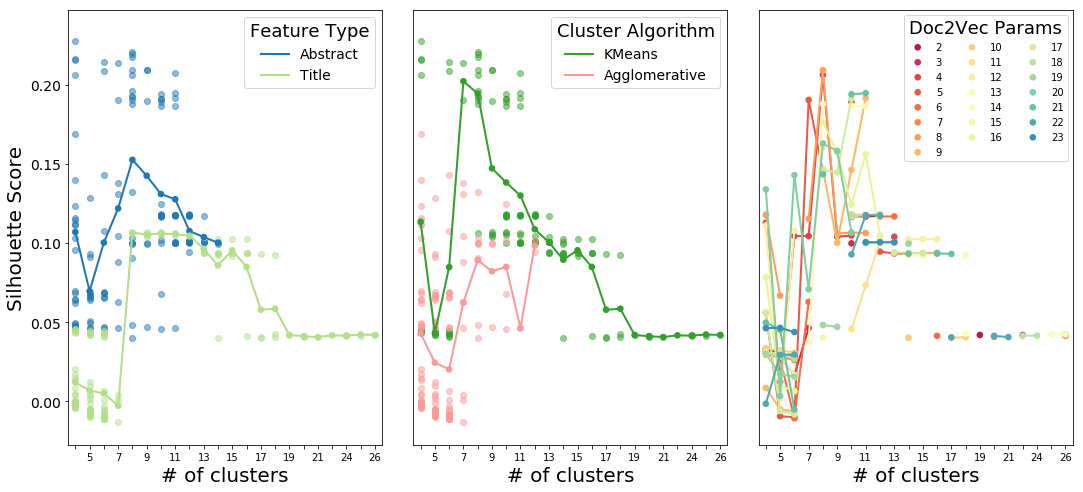

In [34]:
# The below plot shows the same data plotted with three different color schemes to emphasize the roles of 
# different aspects

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (18, 8))
ax1.scatter( df_clust_analysis[df_clust_analysis.feature == 'abstract_features']['nclusts']-4, df_clust_analysis[df_clust_analysis.feature == 'abstract_features']['sscore'], color = sns.color_palette("Paired")[1], alpha = .5, label = None)
ax1.scatter( df_clust_analysis[df_clust_analysis.feature == 'title_features']['nclusts']-4, df_clust_analysis[df_clust_analysis.feature == 'title_features']['sscore'], color = sns.color_palette("Paired")[2], alpha = .5, label=None)
sns.pointplot( x='nclusts', y="sscore", data=df_clust_analysis, hue='feature', palette = sns.color_palette("Paired")[1:3], legend=True, ax= ax1, scale = .75, ci = None)

lines = []
ax2.scatter( df_clust_analysis[df_clust_analysis.cluster_alg == 'kmeans']['nclusts']-4, df_clust_analysis[df_clust_analysis.cluster_alg == 'kmeans']['sscore'], color = sns.color_palette("Paired")[3], alpha = .5, label= None)
ax2.scatter( df_clust_analysis[df_clust_analysis.cluster_alg == 'agglomerative']['nclusts']-4, df_clust_analysis[df_clust_analysis.cluster_alg == 'agglomerative']['sscore'], color = sns.color_palette("Paired")[4], alpha = .5, label = None)
lines.append(sns.pointplot( x='nclusts', y="sscore", data=df_clust_analysis, hue='cluster_alg', palette = sns.color_palette("Paired")[3:5], legend=True, ax= ax2,  scale = .75, ci = None))


sns.pointplot( x='nclusts', y="sscore", data=df_clust_analysis, hue='model_num', palette = sns.color_palette("Spectral", 24), legend=False, ax= ax3,  scale = .75, ci = None)

plot_meta = [['Feature Type', ['Abstract', 'Title']], ['Cluster Algorithm', ['KMeans', 'Agglomerative']], ['Doc2Vec params', [str(ik) for ik in range(2, 24, 1)]]]
for ip, ax in enumerate([ax1, ax2, ax3]):
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('# of clusters')
    ax.legend(labels = plot_meta[ip][1], title = plot_meta[ip][0], prop=dict(size=14), loc=1, title_fontsize = 18)
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
        
ax3.legend(title= 'Doc2Vec Params',  title_fontsize = 18, loc = 1, ncol=3)

ax1.set_ylabel('Silhouette Score')
ax1.yaxis.set_visible(True)

fig.subplots_adjust(wspace=0.1, hspace=0)
# plt.savefig('silscore_feat_clsalg_mdlnum.png')



### 5.2.1 TSNE Plot

TSNE (t-distributed stochastic neighbor embedding) plots are an interesting way to project multi-dimensional data onto a 2D surface. TSNE tends to enhance the visual appearance that data is clustered, but it is still a useful way to get some kind of visual read on the structure of data.  In particular, it's interesting to see the difference in coherence between coloring by section label v. coloring by cluster label.

In [35]:
from sklearn.manifold import TSNE

def fit_tsne(num_clusters, d2v_vecs_df,X_train, **kwargs):
    tsne = TSNE(n_components=2, random_state=43)
    
    #create dataframe for plotting, add components,labels
    tsne_plot_df = pd.DataFrame()
    tsne_plot_df['section'] = X_train['section']

    #get cluster assignments from KMeans
    if ('assigned_labels' in kwargs):
        d2v_clusterst = kwargs['assigned_labels']
    else:
        d2v_clusterst = KMeans(n_clusters=num_clusters, random_state=43).fit_predict(d2v_vecs_df)

    tsne_plot_df['clusters'] = d2v_clusterst

    #fit transform doc2vec word vectors
    Yt = tsne.fit_transform(d2v_vecs_df)
    tsne_plot_df['TSNE_1'] = Yt[:,0]
    tsne_plot_df['TSNE_2'] = Yt[:,1]
    return tsne_plot_df

In [36]:
def make_tsne_plot(tsne_plot_df, num_clusters, **kwargs):
    plt.figure(figsize=(14,14))
    sns.despine(left=True)
    
    if 'color_by' in kwargs:
        color_by = kwargs['color_by']
    else:
        color_by = 'clusters'
        
    sns.scatterplot(x='TSNE_1', y='TSNE_2', hue=color_by, data=tsne_plot_df, palette=sns.color_palette("Spectral", num_clusters), legend='full',
                    edgecolor='black', s=40, alpha=.7).set_title('KMeans {} clusters'.format(num_clusters))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([tsne_plot_df['TSNE_1'].min()*1.2, tsne_plot_df['TSNE_1'].max()*1.2])
    plt.ylim([tsne_plot_df['TSNE_2'].min()*1.2, tsne_plot_df['TSNE_2'].max()*1.2])
    if 'save_name' in kwargs:
        plt.savefig(kwargs['save_name'], format='svg', bbox_inches='tight')



In [37]:
def make_d2v_df(model, df):
    return pd.DataFrame([model.docvecs[ik] for ik in range(len(df))])

In [38]:
feature = 'abstract_features'
model_num = '21' #20

model = Doc2Vec.load('models/d2v_'+feature+'_params_'+model_num+'.model')
doc_vecs_df = make_d2v_df(model, df_agu)

In [39]:
tsne_plot_df = fit_tsne(11, doc_vecs_df, df_agu) #9


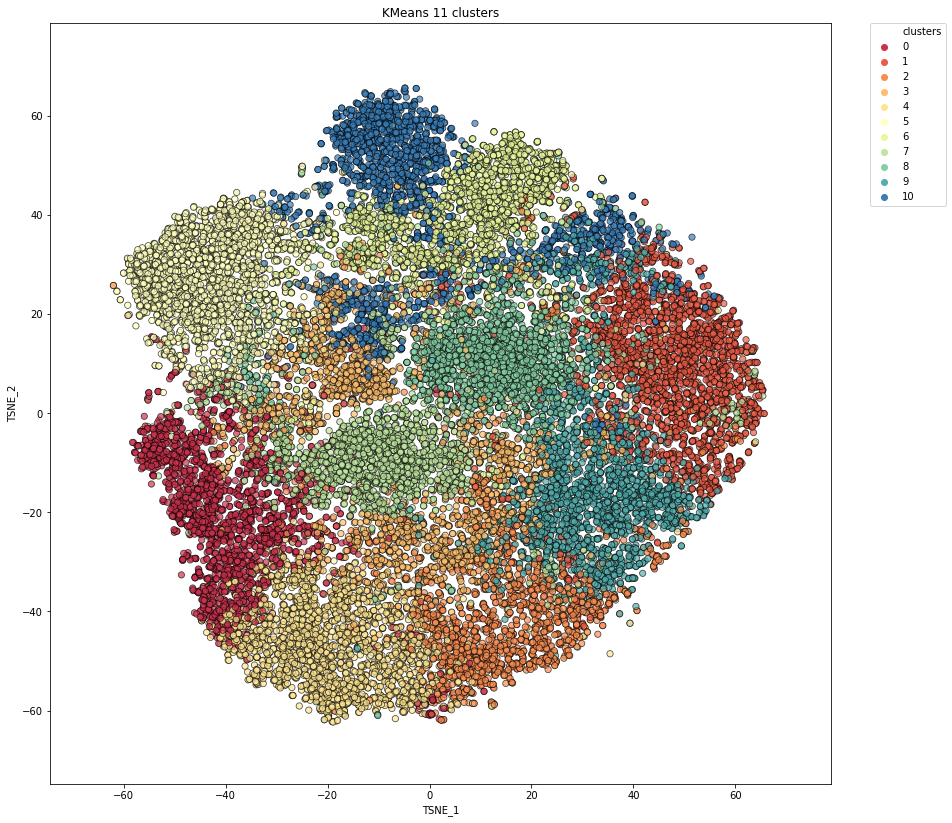

In [704]:
make_tsne_plot(tsne_plot_df, 11)#, save_name = 'clustering/tsne_'+model_num+'_'+feature+'_kmeans_clusterlabels_'+str(11)+'.png')


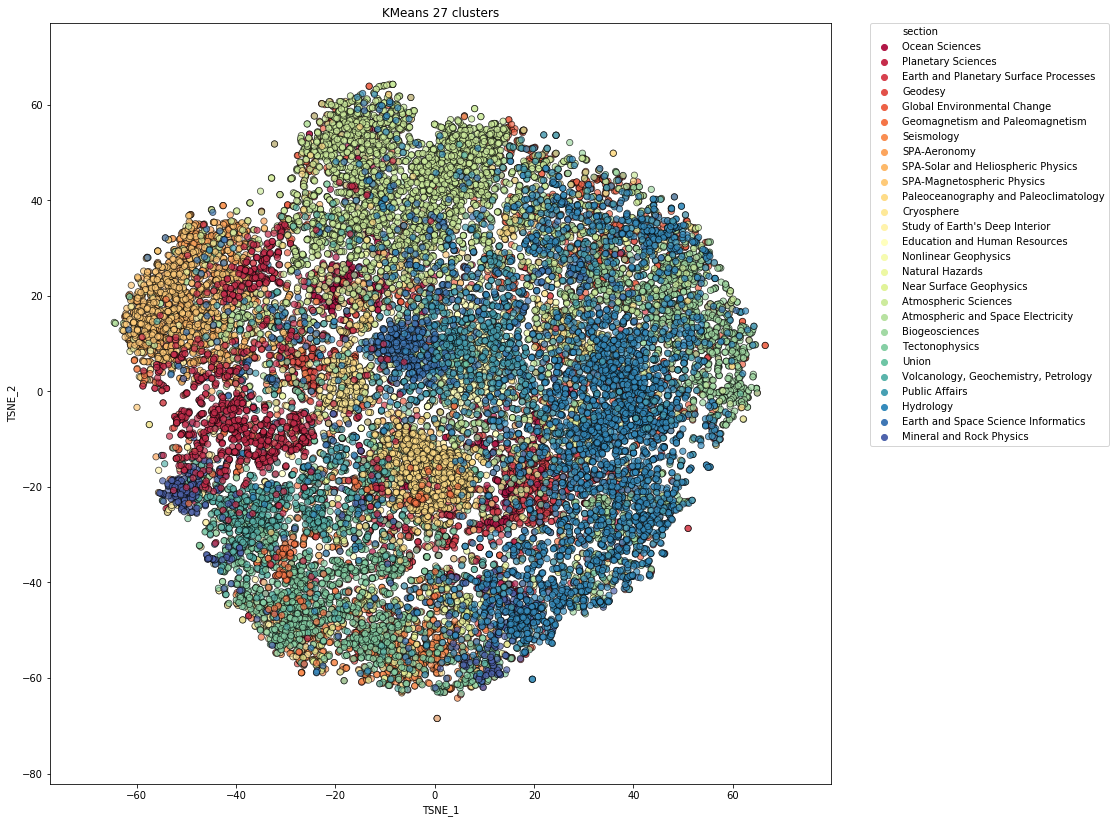

In [40]:
make_tsne_plot(tsne_plot_df, 27, color_by = 'section')#, save_name = 'clustering/tsne_'+model_num+'_'+feature+'_kmeans_sectionlabels_'+str(27)+'.svg')



## 5.3 Comparing Cluster label and section label performance

The below plot looks more closely at the comparison between the silhouette coefficient values per cluster when a clusters are defined with kmeans and by section label.  

In [41]:
from sklearn.metrics import silhouette_score, silhouette_samples

kmeansmodel = KMeans(n_clusters=11, random_state=43).fit(doc_vecs_df)
fdv_clusters = kmeansmodel.predict(doc_vecs_df)
sscores = silhouette_samples(doc_vecs_df, fdv_clusters, metric='cosine')


In [42]:
sscores_sec = silhouette_samples(doc_vecs_df, df_agu.section, metric='cosine')


In [43]:
cluster_df = pd.DataFrame({'sscores': sscores, 'sscores_sec':sscores_sec,'clabels': fdv_clusters, 'section':df_agu.section})


In [44]:
sec_sscores = []
sec_secs = []
sec_grps = cluster_df.groupby('section')
for grp in sec_grps:
    sec_sscores.append(grp[1].sscores_sec.mean())
    sec_secs.append(grp[0])

In [45]:
clus_sscores = []
clus_secs = []
clus_grps = cluster_df.groupby('clabels')
for grp in clus_grps:
    clus_sscores.append(grp[1].sscores.mean())
    clus_secs.append(grp[0])

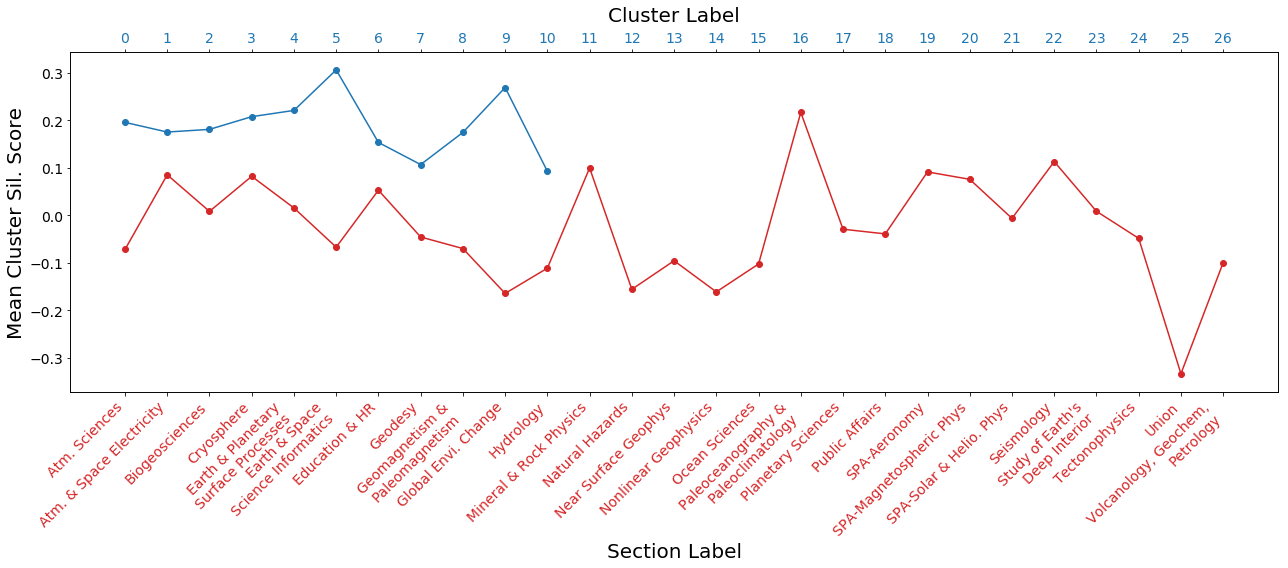

In [47]:
fig, ax1 = plt.subplots(figsize = (18, 8))

color = 'tab:red'
ax1.set_xlabel('Section Label', fontsize = 20)
ax1.set_ylabel('Mean Cluster Sil. Score', fontsize = 20, labelpad=3)
ax1.scatter(xlabels_txt, sec_sscores, color=color)
ax1.plot(xlabels_txt, sec_sscores, color=color)
ax1.tick_params(axis='x', labelcolor=color, rotation=45, labelright=True, labelsize = 14)
ax1.tick_params(axis='y', labelsize = 14)
ax1.set_xticklabels(xlabels_txt, rotation=40, ha='right', fontsize = 14)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
clus_sscores2 = clus_sscores + [None for ik in range(27-len(clus_sscores))]
ax2.scatter([str(ik) for ik in range(27)], clus_sscores2, color=color)
ax2.plot([str(ik) for ik in range(27)], clus_sscores2, color=color)
ax2.tick_params(axis='x', labelcolor=color)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Cluster Label', fontsize = 20,  labelpad=10)
ax2.tick_params(axis='x', labelsize = 14)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('clustering/silscorecompare_'+model_num+'_'+feature+'_kmeans_sectionlabels_'+str(8)+'.png', dpi = 400)

In [60]:
t, p = stats.ttest_ind(sec_sscores, clus_sscores)
print('cluster mean sil. score %.2f +/- %.2f' %( np.mean(clus_sscores), np.std(clus_sscores)))
print('section labels mean sil. score %.2f +/- %.2f' %( np.mean(sec_sscores), np.std(sec_sscores)))
print('ttest comparison probability (unpaired): %.2f' %p)

cluster mean sil. score 0.19 +/- 0.06
section labels mean sil. score -0.03 +/- 0.11
ttest comparison probability (unpaired): 0.00


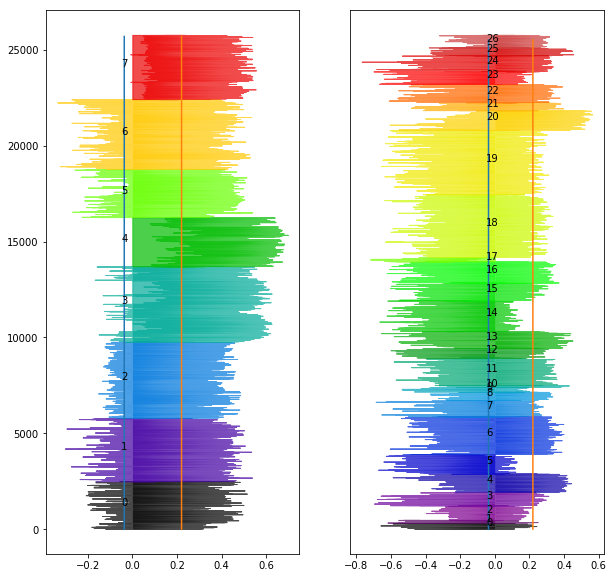

In [471]:
import matplotlib.cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))

n_clusters = 8
y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            cluster_df[cluster_df['clabels'] == i]['sscores']

        ith_cluster_silhouette_values.sort_values()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

y_lower = 10
for i, label in enumerate(list(set(cluster_df['section']))):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            cluster_df[cluster_df['section'] == label]['sscores_sec']

        ith_cluster_silhouette_values.sort_values()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / 27)
        ax2.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
ax2.yaxis.set_visible(False)

ax2.plot([cluster_df['sscores_sec'].mean() for ik in range(len(cluster_df))], [ik for ik in range(len(cluster_df))], label = 'mean section sil score')
ax2.plot([cluster_df['sscores'].mean() for ik in range(len(cluster_df))], [ik for ik in range(len(cluster_df))], label = 'mean cluster sil score')
ax1.plot([cluster_df['sscores_sec'].mean() for ik in range(len(cluster_df))], [ik for ik in range(len(cluster_df))], label = 'mean section sil score')
ax1.plot([cluster_df['sscores'].mean() for ik in range(len(cluster_df))], [ik for ik in range(len(cluster_df))], label = 'mean cluster sil score')


## 6.2 Analyzing Supervised Classifier Performance

In [61]:
# makes a dataframe recording the score and for each num_clusters-ml_alg-model_num-feature-cluster_alg comb

d = {key: [] for key in ['model_num', 'feature', 'cluster_alg', 'nclusts', 'ml_alg', 'score', 'clust_sec']}
for model_num in range(2, 24, 1):
    for feature in ['abstract_features', 'title_features']:
        for cluster_alg in ['kmeans', 'agglomerative']:
            try:
                df_clust_ml_analysis = pd.read_csv('_'.join(['clustering/classifiers_d2v', cluster_alg, str(model_num),feature+'.csv']))#.sort_values(by= 'score', ascending = False).head(3)
                for ml_alg in ['gbc', 'svc']:
                    for clust_sec in ['cl', 'sl']:
                        df_clust_ml_analysis.sort_values(by = ml_alg+'_test_score_'+clust_sec, ascending = False)
                        for ik in range(len(df_clust_ml_analysis)):
                            d['feature'].append(feature)
                            d['cluster_alg'].append(cluster_alg)
                            d['model_num'].append(model_num)
                            d['ml_alg'].append(ml_alg)
                            d['clust_sec'].append(clust_sec)
                            d['nclusts'].append(df_clust_ml_analysis.iloc[ik]['clust_param'])
                            d['score'].append(df_clust_ml_analysis.iloc[ik][ml_alg+'_test_score_'+clust_sec])
            except:
                pass



In [62]:
df_clust_ml_analysis = pd.DataFrame(d)

In [63]:
df_clust_ml_analysis.head()

model_num            feature cluster_alg  nclusts ml_alg     score  \
0          2  abstract_features      kmeans        4    gbc  0.917137   
1          2  abstract_features      kmeans        5    gbc  0.910294   
2          2  abstract_features      kmeans        6    gbc  0.908560   
3          2  abstract_features      kmeans        7    gbc  0.894747   
4          2  abstract_features      kmeans        8    gbc  0.896673   

  clust_sec  
0        cl  
1        cl  
2        cl  
3        cl  
4        cl

In [64]:
df_clust_ml_analysis_cl = df_clust_ml_analysis[df_clust_ml_analysis['clust_sec'] == 'cl']
df_clust_ml_analysis_sl = df_clust_ml_analysis[df_clust_ml_analysis['clust_sec'] == 'sl']

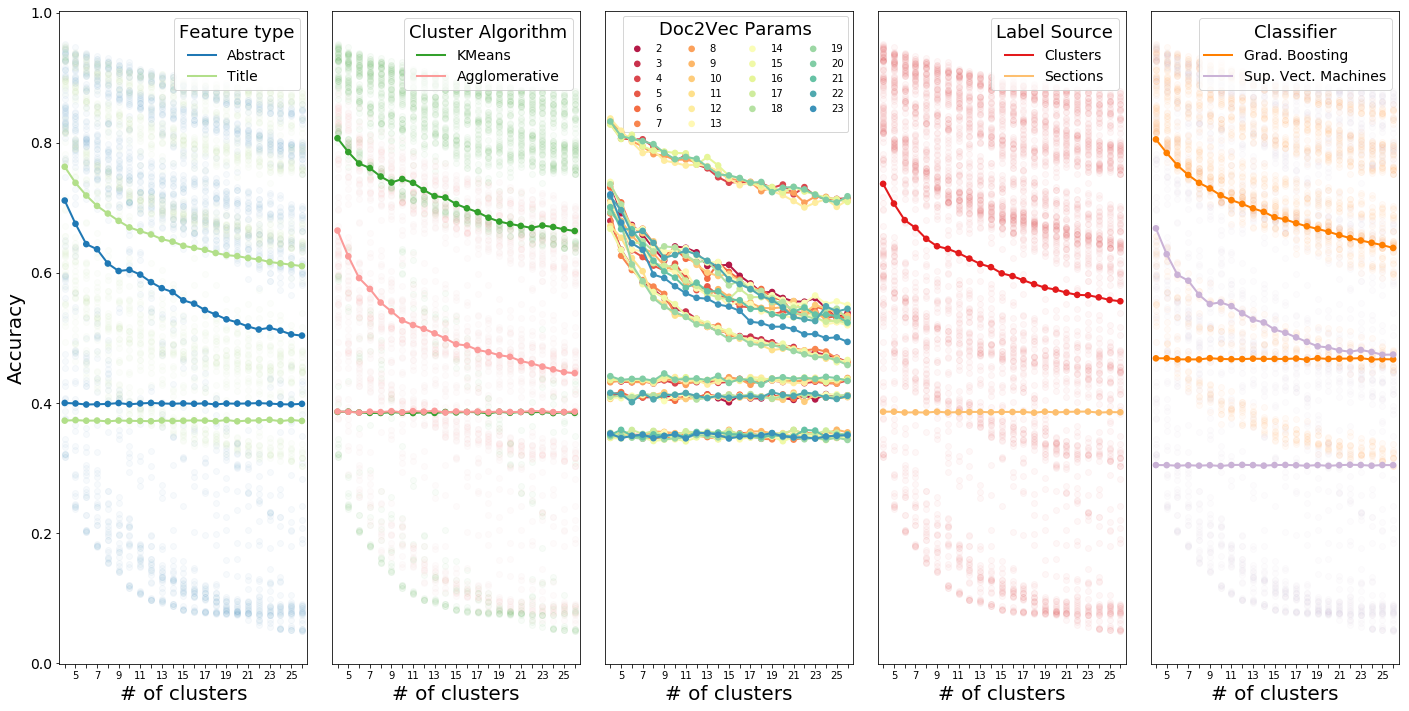

In [65]:

palette_models = sns.diverging_palette(220, 20, n=24)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize = (24, 12))
ax1.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.feature == 'abstract_features']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.feature == 'abstract_features']['score'], color = sns.color_palette("Paired")[1], alpha = .03, label = None)
ax1.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.feature == 'title_features']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.feature == 'title_features']['score'], color = sns.color_palette("Paired")[2], alpha = .03, label=None)
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_cl, hue='feature', palette = sns.color_palette("Paired")[1:3], legend=True, ax= ax1, scale = .75, ci = None)
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_sl, hue='feature', palette = sns.color_palette("Paired")[1:3], legend=True, ax= ax1, scale = .75, ci = None)

ax2.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.cluster_alg == 'kmeans']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.cluster_alg == 'kmeans']['score'], color = sns.color_palette("Paired")[3], alpha = .03, label = None)
ax2.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.cluster_alg == 'agglomerative']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.cluster_alg == 'agglomerative']['score'], color = sns.color_palette("Paired")[4], alpha = .03, label=None)
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_cl, hue='cluster_alg', palette = sns.color_palette("Paired")[3:5], legend=True, ax= ax2,  scale = .75, ci = None)# 'sd')
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_sl, hue='cluster_alg', palette = sns.color_palette("Paired")[3:5], legend=True, ax= ax2,  scale = .75, ci = None)# 'sd')


sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_cl, hue='model_num', palette = sns.color_palette("Spectral", 24), legend=False, ax= ax3,  scale = .75, ci = None)
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_sl, hue='model_num', palette = sns.color_palette("Spectral", 24), legend=False, ax= ax3,  scale = .75, ci = None)


ax4.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.clust_sec == 'cl']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.clust_sec == 'cl']['score'], color = sns.color_palette("Paired")[5], alpha = .03, label = None)
ax4.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.clust_sec == 'sl']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.clust_sec == 'sl']['score'], color = sns.color_palette("Paired")[6], alpha = .03, label=None)
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_cl, hue='clust_sec', palette = sns.color_palette("Paired")[5:6], legend=False, ax= ax4,  scale = .75, ci = None)#'sd')
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_sl, hue='clust_sec', palette = sns.color_palette("Paired")[6:7], legend=False, ax= ax4,  scale = .75, ci = None)#'sd')


ax5.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.ml_alg == 'gbc']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.ml_alg == 'gbc']['score'], color = sns.color_palette("Paired")[7], alpha = .03, label = None)
ax5.scatter( df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.ml_alg == 'svc']['nclusts']-4, df_clust_ml_analysis_cl[df_clust_ml_analysis_cl.ml_alg == 'svc']['score'], color = sns.color_palette("Paired")[8], alpha = .03, label=None)
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_cl, hue='ml_alg', palette = sns.color_palette("Paired")[7:9], legend=False, ax= ax5,  scale = .75, ci = None)#'sd')
sns.pointplot( x='nclusts', y="score", data=df_clust_ml_analysis_sl, hue='ml_alg', palette = sns.color_palette("Paired")[7:9], legend=False, ax= ax5,  scale = .75, ci = None)#'sd')



plot_meta = [['Feature type', ['Abstract', 'Title']], ['Cluster Algorithm', ['KMeans', 'Agglomerative']], ['Doc2Vec params', [str(ik) for ik in range(2, 24, 1)]], ['Label Source', ['Clusters', 'Sections']], ['Classifier', ['Grad. Boosting', 'Sup. Vect. Machines']]]
for ip, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('# of clusters')
    if ip !=2:
        ax.legend(labels = plot_meta[ip][1], title = plot_meta[ip][0], prop=dict(size=14), loc=1, title_fontsize = 18)
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 


handles,labels=ax3.get_legend_handles_labels()
ax3.legend(handles[:22], labels[:22],title= 'Doc2Vec Params',  title_fontsize = 18, loc = 1, ncol=4)
ax1.yaxis.set_visible(True)
ax1.set_ylabel('Accuracy')
ax1.yaxis.label.set_size(20)

fig.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('accurscore_feat_clsalg_mdlnum_lblsrc_class.png')


In [47]:
resultNodes = list(set(df_agu['section'])) + list(set(df_agu['session']))

In [545]:
X_test_inds = ast.literal_eval(row[3])
X_train_inds = ast.literal_eval(row[2])


y_test_sl = cluster_df['section'].iloc[X_test_inds]
y_test_cl = cluster_df['clabels'].iloc[X_test_inds]

y_train_sl = cluster_df['section'].iloc[X_train_inds]
y_train_cl = cluster_df['clabels'].iloc[X_train_inds]

from sklearn.ensemble import GradientBoostingClassifier

gbc_sl = GradientBoostingClassifier()
gbc_sl.fit(doc_vecs_df.iloc[X_train_inds], y_train_sl)
y_pred_sl = gbc_sl.predict(doc_vecs_df.iloc[X_test_inds])


In [546]:
gbc_cl = GradientBoostingClassifier()
gbc_cl.fit(doc_vecs_df.iloc[X_train_inds], y_train_cl)
y_pred_cl = gbc_cl.predict(doc_vecs_df.iloc[X_test_inds])

In [547]:
df_clust_ml_compare = pd.DataFrame({'y_test_cl':y_test_cl, 'y_test_sl':y_test_sl, 'gbc_y_pred_cl':y_pred_cl, 'gbc_y_pred_sl':y_pred_sl})



In [551]:
cl_grps = df_clust_ml_compare.groupby('y_test_cl')
clus_scores = []
clus_secs = []

for grp in cl_grps:
    clus_scores.append(len(grp[1][grp[1]['gbc_y_pred_cl'] == grp[0]])/len(grp[1]))
    clus_secs.append(grp[0])
    
    
sl_grps = df_clust_ml_compare.groupby('y_test_sl')
sec_scores = []
sec_secs = []

for grp in sl_grps:
    sec_scores.append(len(grp[1][grp[1]['gbc_y_pred_sl'] == grp[0]])/len(grp[1]))
    sec_secs.append(grp[0])
    

In [486]:
df_clust_ml_analysis[df_clust_ml_analysis.nclusts >6].sort_values(by = 'score', ascending = False)

model_num            feature    cluster_alg  nclusts ml_alg     score  \
5155         16  abstract_features         kmeans        7    gbc  0.933839   
3684         12  abstract_features         kmeans        8    gbc  0.929572   
2211          8  abstract_features         kmeans        7    gbc  0.929183   
6627         20  abstract_features         kmeans        7    gbc  0.928030   
3683         12  abstract_features         kmeans        7    gbc  0.926056   
740           4  abstract_features         kmeans        8    gbc  0.925861   
4649         14     title_features         kmeans        7    svc  0.925112   
3685         12  abstract_features         kmeans        9    gbc  0.925083   
234           2     title_features         kmeans        8    svc  0.924304   
6628         20  abstract_features         kmeans        8    gbc  0.923556   
5156         16  abstract_features         kmeans        8    gbc  0.923346   
5158         16  abstract_features         kmeans       10    gbc  0.923346   
7594         22     title_features         kmeans        8    svc  0.922957   
7593         22     title_features         kmeans        7    svc  0.922748   
739           4  abstract_features         kmeans        7    gbc  0.922568   
3177         10     title_features         kmeans        7    svc  0.922179   
3178         10     title_features         kmeans        8    svc  0.921595   
6121         18     title_features         kmeans        7    svc  0.921580   
5524         17  abstract_features         kmeans        8    gbc  0.921580   
2579          9  abstract_features         kmeans        7    gbc  0.920623   
4650         14     title_features         kmeans        8    svc  0.920607   
5157         16  abstract_features         kmeans        9    gbc  0.919844   
1107          5  abstract_features         kmeans        7    gbc  0.919634   
2213          8  abstract_features         kmeans        9    gbc  0.919455   
2214          8  abstract_features         kmeans       10    gbc  0.919050   
2212          8  abstract_features         kmeans        8    gbc  0.918677   
5523         17  abstract_features         kmeans        7    gbc  0.918467   
6629         20  abstract_features         kmeans        9    gbc  0.918077   
233           2     title_features         kmeans        7    svc  0.917704   
1705          6     title_features         kmeans        7    svc  0.917510   
...         ...                ...            ...      ...    ...       ...   
4114         13  abstract_features         kmeans       24    svc  0.073555   
1904          7  abstract_features         kmeans       22    svc  0.072374   
6320         19  abstract_features         kmeans       22    svc  0.066978   
4940         15  abstract_features  agglomerative       22    svc  0.066732   
4943         15  abstract_features  agglomerative       25    svc  0.066537   
4944         15  abstract_features  agglomerative       26    svc  0.066342   
6319         19  abstract_features         kmeans       21    svc  0.065966   
4941         15  abstract_features  agglomerative       23    svc  0.065953   
4942         15  abstract_features  agglomerative       24    svc  0.064397   
7792         23  abstract_features         kmeans       22    svc  0.063995   
3377         11  abstract_features         kmeans       23    svc  0.062622   
2000          7  abstract_features  agglomerative       26    svc  0.062074   
4848         15  abstract_features         kmeans       22    svc  0.058160   
7795         23  abstract_features         kmeans       25    svc  0.056971   
7793         23  abstract_features         kmeans       23    svc  0.056237   
6322         19  abstract_features         kmeans       24    svc  0.054475   
1907          7  abstract_features         kmeans       25    svc  0.054301   
1906          7  abstract_features         kmeans       24    svc  0.054096   
7796         23  abstract_features         kmeans       

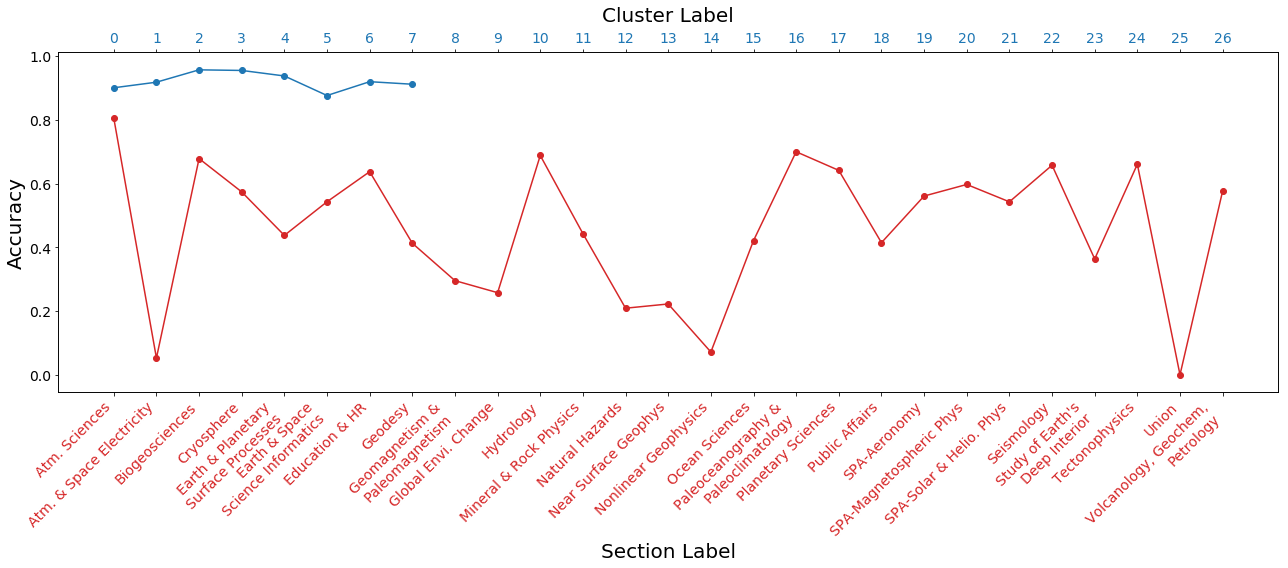

In [564]:
fig, ax1 = plt.subplots(figsize = (18, 8))

color = 'tab:red'
ax1.set_xlabel('Section Label', fontsize = 20)
ax1.set_ylabel('Accuracy', fontsize = 20, labelpad=3)
ax1.scatter(xlabels_txt, sec_scores, color=color, label = 'GBC predict section labels')
ax1.plot(xlabels_txt, sec_scores, color=color)
ax1.tick_params(axis='x', labelcolor=color, rotation=45, labelright=True, labelsize = 14)
ax1.tick_params(axis='y', labelsize = 14)
ax1.set_xticklabels(xlabels_txt, rotation=40, ha='right', fontsize = 14)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
clus_scores2 = clus_scores + [None for ik in range(19)]
ax2.scatter([str(ik) for ik in range(27)], clus_scores2, color=color)
ax2.plot([str(ik) for ik in range(27)], clus_scores2, color=color)
ax2.tick_params(axis='x', labelcolor=color)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Cluster Label', fontsize = 20,  labelpad=10)
ax2.tick_params(axis='x', labelsize = 14)

fig.tight_layout()
plt.savefig('clustering/accuracycompare_'+model_num+'_'+feature+'_gbc_sectionlabels_'+str(8)+'.png', dpi = 400)